# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [14]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

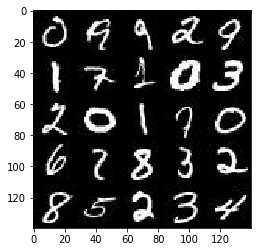

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

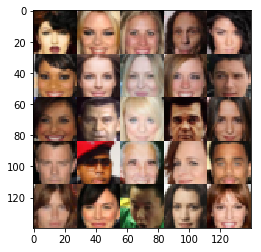

In [16]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [17]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [18]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learn_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [27]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse) as d_scope:
        x = tf.layers.conv2d(images, 64, 5, 2, 'same')
        x = tf.nn.relu(x)
        
        x1 = tf.layers.conv2d(x, 128, 5, 2, 'same')
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(x1, 256, 5, 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.reshape(x2, [-1, 4 * 4 * 256])
        logits = tf.layers.dense(x3, 1, activation=None)
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [28]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse= not is_train) as g_scope:
        x = tf.layers.dense(z, 4 * 4 * 256)
        x = tf.reshape(x, [-1, 4, 4, 256])
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(alpha * x, x)

        x1 = tf.layers.conv2d_transpose(x, 128, 4, 1, 'valid')
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 64, 5, 2, 'same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, 2, 'same')
        output = tf.tanh(logits)
        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [29]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    d_output_real, d_logits_real = discriminator(input_real, reuse=False)
    g_output = generator(input_z, out_channel_dim, is_train=True)
    d_output_fake, d_logits_fake = discriminator(g_output, reuse=True)
    
    d_target_real = tf.ones_like(d_logits_real) * 0.9
    d_target_fake = tf.zeros_like(d_logits_fake)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=d_target_real))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=d_target_fake))
    
    d_loss = d_loss_real + d_loss_fake
    g_target = tf.ones_like(d_logits_fake)
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=g_target))
    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [30]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    g_vars = [var for var in train_vars if var.name.startswith('generator')]
    d_vars = [var for var in train_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_train_op = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        
    return d_train_op, g_train_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [31]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [32]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    real_input, z_input, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    iteration = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                iteration += 1
                batch_images = batch_images * 2
                z = np.random.uniform(-1, 1, [batch_size, z_dim])
                sess.run(d_opt, feed_dict={real_input: batch_images, z_input: z,
                                                    learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={real_input: batch_images, z_input: z,
                                                    learn_rate: learning_rate})
                sess.run(g_opt, feed_dict={real_input: batch_images, z_input: z,
                                                    learn_rate: learning_rate})
                
                if iteration % 10 == 0:
                    d, g = sess.run([d_loss, g_loss], feed_dict={real_input: batch_images, z_input: z,
                                                                 learn_rate: learning_rate})
                    print("Epoch: {}/{}".format(epoch_i + 1, epoch_count),
                          "Iteration: {}".format(iteration),
                          "Discrim. Loss: {:.4f}".format(d),
                          "Generat. Loss: {:.4f}".format(g))
                
                if iteration % 100 == 0:
                    show_generator_output(sess, 9, z_input, data_shape[3], data_image_mode)    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch: 1/2 Iteration: 10 Discrim. Loss: 2.3406 Generat. Loss: 1.3514
Epoch: 1/2 Iteration: 20 Discrim. Loss: 1.5515 Generat. Loss: 1.7769
Epoch: 1/2 Iteration: 30 Discrim. Loss: 1.3017 Generat. Loss: 3.7883
Epoch: 1/2 Iteration: 40 Discrim. Loss: 0.8346 Generat. Loss: 3.9046
Epoch: 1/2 Iteration: 50 Discrim. Loss: 1.9954 Generat. Loss: 0.2538
Epoch: 1/2 Iteration: 60 Discrim. Loss: 1.3887 Generat. Loss: 0.6837
Epoch: 1/2 Iteration: 70 Discrim. Loss: 2.1361 Generat. Loss: 0.3279
Epoch: 1/2 Iteration: 80 Discrim. Loss: 1.1202 Generat. Loss: 0.9885
Epoch: 1/2 Iteration: 90 Discrim. Loss: 1.1771 Generat. Loss: 2.2309
Epoch: 1/2 Iteration: 100 Discrim. Loss: 1.8283 Generat. Loss: 0.3158


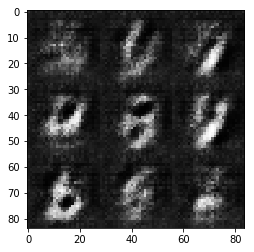

Epoch: 1/2 Iteration: 110 Discrim. Loss: 1.5065 Generat. Loss: 1.7118
Epoch: 1/2 Iteration: 120 Discrim. Loss: 2.0982 Generat. Loss: 0.2197
Epoch: 1/2 Iteration: 130 Discrim. Loss: 1.4130 Generat. Loss: 1.1109
Epoch: 1/2 Iteration: 140 Discrim. Loss: 1.3344 Generat. Loss: 1.4218
Epoch: 1/2 Iteration: 150 Discrim. Loss: 1.4032 Generat. Loss: 0.4932
Epoch: 1/2 Iteration: 160 Discrim. Loss: 1.6224 Generat. Loss: 0.3861
Epoch: 1/2 Iteration: 170 Discrim. Loss: 1.1867 Generat. Loss: 0.8065
Epoch: 1/2 Iteration: 180 Discrim. Loss: 1.1868 Generat. Loss: 0.8632
Epoch: 1/2 Iteration: 190 Discrim. Loss: 1.1368 Generat. Loss: 1.7496
Epoch: 1/2 Iteration: 200 Discrim. Loss: 1.3433 Generat. Loss: 2.1125


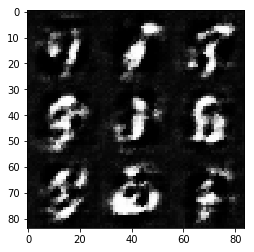

Epoch: 1/2 Iteration: 210 Discrim. Loss: 1.1207 Generat. Loss: 0.8101
Epoch: 1/2 Iteration: 220 Discrim. Loss: 2.1975 Generat. Loss: 0.2075
Epoch: 1/2 Iteration: 230 Discrim. Loss: 1.5801 Generat. Loss: 0.3795
Epoch: 1/2 Iteration: 240 Discrim. Loss: 1.4841 Generat. Loss: 0.4193
Epoch: 1/2 Iteration: 250 Discrim. Loss: 1.2851 Generat. Loss: 1.9341
Epoch: 1/2 Iteration: 260 Discrim. Loss: 1.2923 Generat. Loss: 1.0245
Epoch: 1/2 Iteration: 270 Discrim. Loss: 1.2855 Generat. Loss: 0.8440
Epoch: 1/2 Iteration: 280 Discrim. Loss: 1.1823 Generat. Loss: 0.9184
Epoch: 1/2 Iteration: 290 Discrim. Loss: 1.2246 Generat. Loss: 0.7881
Epoch: 1/2 Iteration: 300 Discrim. Loss: 1.4532 Generat. Loss: 0.5670


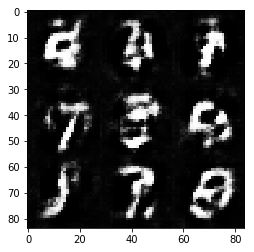

Epoch: 1/2 Iteration: 310 Discrim. Loss: 1.1810 Generat. Loss: 1.3811
Epoch: 1/2 Iteration: 320 Discrim. Loss: 1.2968 Generat. Loss: 0.9777
Epoch: 1/2 Iteration: 330 Discrim. Loss: 1.7797 Generat. Loss: 0.3154
Epoch: 1/2 Iteration: 340 Discrim. Loss: 1.8053 Generat. Loss: 0.2824
Epoch: 1/2 Iteration: 350 Discrim. Loss: 1.2202 Generat. Loss: 0.7742
Epoch: 1/2 Iteration: 360 Discrim. Loss: 1.3940 Generat. Loss: 1.3823
Epoch: 1/2 Iteration: 370 Discrim. Loss: 1.5606 Generat. Loss: 0.4416
Epoch: 1/2 Iteration: 380 Discrim. Loss: 1.2051 Generat. Loss: 1.0506
Epoch: 1/2 Iteration: 390 Discrim. Loss: 1.2115 Generat. Loss: 1.1696
Epoch: 1/2 Iteration: 400 Discrim. Loss: 1.2672 Generat. Loss: 0.7345


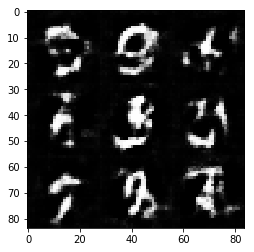

Epoch: 1/2 Iteration: 410 Discrim. Loss: 1.6526 Generat. Loss: 0.3665
Epoch: 1/2 Iteration: 420 Discrim. Loss: 1.2807 Generat. Loss: 0.9373
Epoch: 1/2 Iteration: 430 Discrim. Loss: 2.1479 Generat. Loss: 0.2644
Epoch: 1/2 Iteration: 440 Discrim. Loss: 1.8612 Generat. Loss: 0.3087
Epoch: 1/2 Iteration: 450 Discrim. Loss: 1.1511 Generat. Loss: 0.7659
Epoch: 1/2 Iteration: 460 Discrim. Loss: 1.3591 Generat. Loss: 0.5683
Epoch: 1/2 Iteration: 470 Discrim. Loss: 1.1780 Generat. Loss: 1.1098
Epoch: 1/2 Iteration: 480 Discrim. Loss: 1.4770 Generat. Loss: 0.4844
Epoch: 1/2 Iteration: 490 Discrim. Loss: 1.3264 Generat. Loss: 0.8643
Epoch: 1/2 Iteration: 500 Discrim. Loss: 1.3532 Generat. Loss: 0.8710


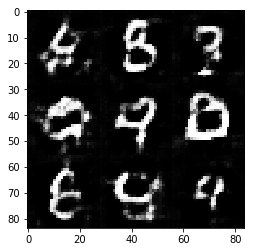

Epoch: 1/2 Iteration: 510 Discrim. Loss: 1.4090 Generat. Loss: 0.5499
Epoch: 1/2 Iteration: 520 Discrim. Loss: 1.4496 Generat. Loss: 0.5115
Epoch: 1/2 Iteration: 530 Discrim. Loss: 1.8205 Generat. Loss: 0.3025
Epoch: 1/2 Iteration: 540 Discrim. Loss: 1.2024 Generat. Loss: 0.7583
Epoch: 1/2 Iteration: 550 Discrim. Loss: 1.4323 Generat. Loss: 0.4768
Epoch: 1/2 Iteration: 560 Discrim. Loss: 1.4272 Generat. Loss: 0.4680
Epoch: 1/2 Iteration: 570 Discrim. Loss: 1.4618 Generat. Loss: 0.4675
Epoch: 1/2 Iteration: 580 Discrim. Loss: 1.8036 Generat. Loss: 0.3154
Epoch: 1/2 Iteration: 590 Discrim. Loss: 1.2670 Generat. Loss: 0.6189
Epoch: 1/2 Iteration: 600 Discrim. Loss: 1.6939 Generat. Loss: 0.3340


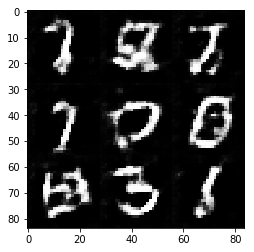

Epoch: 1/2 Iteration: 610 Discrim. Loss: 1.4641 Generat. Loss: 0.4441
Epoch: 1/2 Iteration: 620 Discrim. Loss: 1.5066 Generat. Loss: 0.4249
Epoch: 1/2 Iteration: 630 Discrim. Loss: 1.5574 Generat. Loss: 0.3997
Epoch: 1/2 Iteration: 640 Discrim. Loss: 1.6718 Generat. Loss: 0.3651
Epoch: 1/2 Iteration: 650 Discrim. Loss: 1.6715 Generat. Loss: 0.3425
Epoch: 1/2 Iteration: 660 Discrim. Loss: 1.3595 Generat. Loss: 0.5890
Epoch: 1/2 Iteration: 670 Discrim. Loss: 1.4781 Generat. Loss: 1.3347
Epoch: 1/2 Iteration: 680 Discrim. Loss: 1.1894 Generat. Loss: 0.8303
Epoch: 1/2 Iteration: 690 Discrim. Loss: 1.3284 Generat. Loss: 0.6063
Epoch: 1/2 Iteration: 700 Discrim. Loss: 1.2805 Generat. Loss: 0.5684


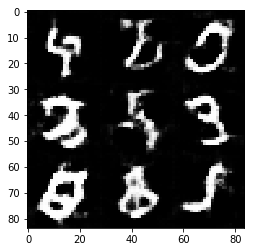

Epoch: 1/2 Iteration: 710 Discrim. Loss: 1.7056 Generat. Loss: 0.3497
Epoch: 1/2 Iteration: 720 Discrim. Loss: 1.0307 Generat. Loss: 1.3208
Epoch: 1/2 Iteration: 730 Discrim. Loss: 1.5278 Generat. Loss: 0.4218
Epoch: 1/2 Iteration: 740 Discrim. Loss: 1.3737 Generat. Loss: 0.5885
Epoch: 1/2 Iteration: 750 Discrim. Loss: 2.1959 Generat. Loss: 0.2025
Epoch: 1/2 Iteration: 760 Discrim. Loss: 1.3624 Generat. Loss: 0.5459
Epoch: 1/2 Iteration: 770 Discrim. Loss: 1.4968 Generat. Loss: 0.4260
Epoch: 1/2 Iteration: 780 Discrim. Loss: 1.2719 Generat. Loss: 1.2288
Epoch: 1/2 Iteration: 790 Discrim. Loss: 1.2412 Generat. Loss: 0.5715
Epoch: 1/2 Iteration: 800 Discrim. Loss: 1.1869 Generat. Loss: 0.6906


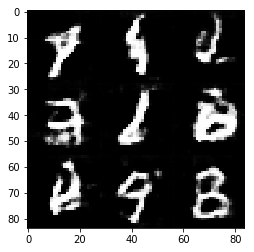

Epoch: 1/2 Iteration: 810 Discrim. Loss: 1.5272 Generat. Loss: 0.4004
Epoch: 1/2 Iteration: 820 Discrim. Loss: 0.9610 Generat. Loss: 1.1783
Epoch: 1/2 Iteration: 830 Discrim. Loss: 1.2805 Generat. Loss: 0.5862
Epoch: 1/2 Iteration: 840 Discrim. Loss: 1.1320 Generat. Loss: 0.8953
Epoch: 1/2 Iteration: 850 Discrim. Loss: 1.3297 Generat. Loss: 0.5571
Epoch: 1/2 Iteration: 860 Discrim. Loss: 2.0510 Generat. Loss: 0.2658
Epoch: 1/2 Iteration: 870 Discrim. Loss: 1.3891 Generat. Loss: 0.4815
Epoch: 1/2 Iteration: 880 Discrim. Loss: 2.2146 Generat. Loss: 0.1961
Epoch: 1/2 Iteration: 890 Discrim. Loss: 1.2921 Generat. Loss: 0.6919
Epoch: 1/2 Iteration: 900 Discrim. Loss: 1.6561 Generat. Loss: 0.3448


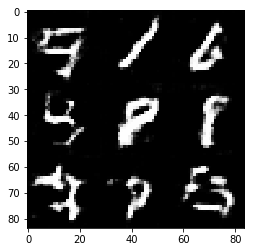

Epoch: 1/2 Iteration: 910 Discrim. Loss: 1.2596 Generat. Loss: 0.7082
Epoch: 1/2 Iteration: 920 Discrim. Loss: 1.9798 Generat. Loss: 0.2447
Epoch: 1/2 Iteration: 930 Discrim. Loss: 1.4178 Generat. Loss: 1.2239
Epoch: 1/2 Iteration: 940 Discrim. Loss: 1.6788 Generat. Loss: 0.3422
Epoch: 1/2 Iteration: 950 Discrim. Loss: 1.2955 Generat. Loss: 0.5837
Epoch: 1/2 Iteration: 960 Discrim. Loss: 1.2153 Generat. Loss: 0.6341
Epoch: 1/2 Iteration: 970 Discrim. Loss: 1.2320 Generat. Loss: 0.7051
Epoch: 1/2 Iteration: 980 Discrim. Loss: 1.2039 Generat. Loss: 0.6679
Epoch: 1/2 Iteration: 990 Discrim. Loss: 1.2317 Generat. Loss: 0.6764
Epoch: 1/2 Iteration: 1000 Discrim. Loss: 1.3978 Generat. Loss: 0.4882


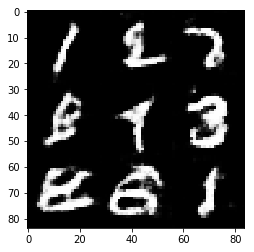

Epoch: 1/2 Iteration: 1010 Discrim. Loss: 1.6189 Generat. Loss: 0.3550
Epoch: 1/2 Iteration: 1020 Discrim. Loss: 1.6622 Generat. Loss: 0.3543
Epoch: 1/2 Iteration: 1030 Discrim. Loss: 1.3462 Generat. Loss: 0.5448
Epoch: 1/2 Iteration: 1040 Discrim. Loss: 1.6928 Generat. Loss: 0.3558
Epoch: 1/2 Iteration: 1050 Discrim. Loss: 1.0608 Generat. Loss: 1.4565
Epoch: 1/2 Iteration: 1060 Discrim. Loss: 1.3567 Generat. Loss: 0.6141
Epoch: 1/2 Iteration: 1070 Discrim. Loss: 1.3532 Generat. Loss: 0.5466
Epoch: 1/2 Iteration: 1080 Discrim. Loss: 1.9708 Generat. Loss: 0.2570
Epoch: 1/2 Iteration: 1090 Discrim. Loss: 1.1808 Generat. Loss: 0.6620
Epoch: 1/2 Iteration: 1100 Discrim. Loss: 1.2013 Generat. Loss: 0.7016


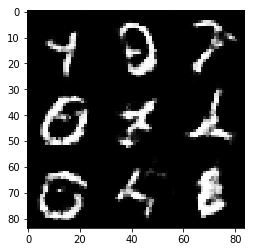

Epoch: 1/2 Iteration: 1110 Discrim. Loss: 1.7330 Generat. Loss: 0.3404
Epoch: 1/2 Iteration: 1120 Discrim. Loss: 1.3682 Generat. Loss: 0.5371
Epoch: 1/2 Iteration: 1130 Discrim. Loss: 1.3233 Generat. Loss: 0.5322
Epoch: 1/2 Iteration: 1140 Discrim. Loss: 1.1355 Generat. Loss: 0.6334
Epoch: 1/2 Iteration: 1150 Discrim. Loss: 1.6678 Generat. Loss: 0.3481
Epoch: 1/2 Iteration: 1160 Discrim. Loss: 1.9438 Generat. Loss: 0.2604
Epoch: 1/2 Iteration: 1170 Discrim. Loss: 3.1278 Generat. Loss: 0.1009
Epoch: 1/2 Iteration: 1180 Discrim. Loss: 1.5129 Generat. Loss: 0.4194
Epoch: 1/2 Iteration: 1190 Discrim. Loss: 1.1295 Generat. Loss: 0.7246
Epoch: 1/2 Iteration: 1200 Discrim. Loss: 1.0448 Generat. Loss: 0.8373


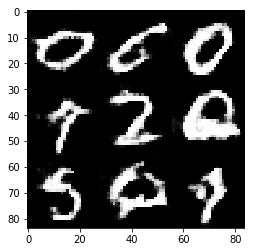

Epoch: 1/2 Iteration: 1210 Discrim. Loss: 1.3710 Generat. Loss: 0.4877
Epoch: 1/2 Iteration: 1220 Discrim. Loss: 1.4108 Generat. Loss: 0.4729
Epoch: 1/2 Iteration: 1230 Discrim. Loss: 1.2385 Generat. Loss: 0.6274
Epoch: 1/2 Iteration: 1240 Discrim. Loss: 1.2788 Generat. Loss: 0.6173
Epoch: 1/2 Iteration: 1250 Discrim. Loss: 1.9049 Generat. Loss: 0.2778
Epoch: 1/2 Iteration: 1260 Discrim. Loss: 2.0667 Generat. Loss: 0.2349
Epoch: 1/2 Iteration: 1270 Discrim. Loss: 1.5115 Generat. Loss: 0.4386
Epoch: 1/2 Iteration: 1280 Discrim. Loss: 1.1670 Generat. Loss: 0.6786
Epoch: 1/2 Iteration: 1290 Discrim. Loss: 4.6931 Generat. Loss: 0.0349
Epoch: 1/2 Iteration: 1300 Discrim. Loss: 1.0702 Generat. Loss: 0.8298


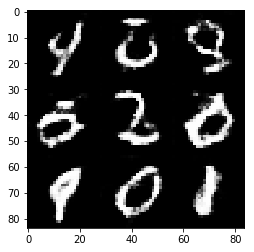

Epoch: 1/2 Iteration: 1310 Discrim. Loss: 1.0977 Generat. Loss: 0.6870
Epoch: 1/2 Iteration: 1320 Discrim. Loss: 1.5723 Generat. Loss: 0.4035
Epoch: 1/2 Iteration: 1330 Discrim. Loss: 1.1664 Generat. Loss: 0.6437
Epoch: 1/2 Iteration: 1340 Discrim. Loss: 1.3032 Generat. Loss: 0.5422
Epoch: 1/2 Iteration: 1350 Discrim. Loss: 1.5313 Generat. Loss: 0.4253
Epoch: 1/2 Iteration: 1360 Discrim. Loss: 1.4427 Generat. Loss: 0.5323
Epoch: 1/2 Iteration: 1370 Discrim. Loss: 2.2684 Generat. Loss: 0.2376
Epoch: 1/2 Iteration: 1380 Discrim. Loss: 1.3777 Generat. Loss: 0.4939
Epoch: 1/2 Iteration: 1390 Discrim. Loss: 1.1385 Generat. Loss: 0.7091
Epoch: 1/2 Iteration: 1400 Discrim. Loss: 1.3522 Generat. Loss: 0.5185


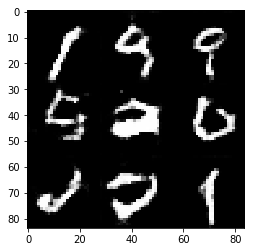

Epoch: 1/2 Iteration: 1410 Discrim. Loss: 1.4673 Generat. Loss: 0.4524
Epoch: 1/2 Iteration: 1420 Discrim. Loss: 1.1550 Generat. Loss: 1.8461
Epoch: 1/2 Iteration: 1430 Discrim. Loss: 1.3235 Generat. Loss: 1.6673
Epoch: 1/2 Iteration: 1440 Discrim. Loss: 1.6143 Generat. Loss: 0.3609
Epoch: 1/2 Iteration: 1450 Discrim. Loss: 1.4703 Generat. Loss: 0.4341
Epoch: 1/2 Iteration: 1460 Discrim. Loss: 1.2320 Generat. Loss: 0.6470
Epoch: 1/2 Iteration: 1470 Discrim. Loss: 1.0911 Generat. Loss: 0.7758
Epoch: 1/2 Iteration: 1480 Discrim. Loss: 1.1764 Generat. Loss: 0.6577
Epoch: 1/2 Iteration: 1490 Discrim. Loss: 0.9650 Generat. Loss: 1.0002
Epoch: 1/2 Iteration: 1500 Discrim. Loss: 1.4266 Generat. Loss: 0.4885


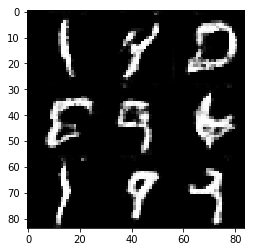

Epoch: 1/2 Iteration: 1510 Discrim. Loss: 1.1082 Generat. Loss: 0.7576
Epoch: 1/2 Iteration: 1520 Discrim. Loss: 1.6775 Generat. Loss: 0.3464
Epoch: 1/2 Iteration: 1530 Discrim. Loss: 1.4799 Generat. Loss: 0.4332
Epoch: 1/2 Iteration: 1540 Discrim. Loss: 1.2724 Generat. Loss: 0.5618
Epoch: 1/2 Iteration: 1550 Discrim. Loss: 1.7361 Generat. Loss: 0.3155
Epoch: 1/2 Iteration: 1560 Discrim. Loss: 2.6852 Generat. Loss: 3.3685
Epoch: 1/2 Iteration: 1570 Discrim. Loss: 0.9278 Generat. Loss: 1.0985
Epoch: 1/2 Iteration: 1580 Discrim. Loss: 1.1096 Generat. Loss: 0.7044
Epoch: 1/2 Iteration: 1590 Discrim. Loss: 1.5975 Generat. Loss: 0.4053
Epoch: 1/2 Iteration: 1600 Discrim. Loss: 1.4448 Generat. Loss: 0.4838


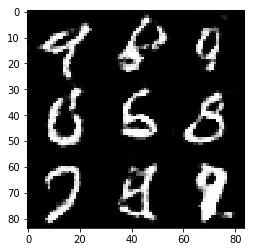

Epoch: 1/2 Iteration: 1610 Discrim. Loss: 2.0443 Generat. Loss: 0.2455
Epoch: 1/2 Iteration: 1620 Discrim. Loss: 1.7083 Generat. Loss: 0.3394
Epoch: 1/2 Iteration: 1630 Discrim. Loss: 1.1750 Generat. Loss: 0.6676
Epoch: 1/2 Iteration: 1640 Discrim. Loss: 1.1788 Generat. Loss: 0.6654
Epoch: 1/2 Iteration: 1650 Discrim. Loss: 1.0797 Generat. Loss: 0.8208
Epoch: 1/2 Iteration: 1660 Discrim. Loss: 1.0426 Generat. Loss: 0.8644
Epoch: 1/2 Iteration: 1670 Discrim. Loss: 0.9246 Generat. Loss: 0.9136
Epoch: 1/2 Iteration: 1680 Discrim. Loss: 1.3142 Generat. Loss: 0.6255
Epoch: 1/2 Iteration: 1690 Discrim. Loss: 1.3058 Generat. Loss: 0.5605
Epoch: 1/2 Iteration: 1700 Discrim. Loss: 1.9258 Generat. Loss: 0.2835


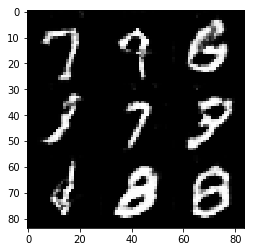

Epoch: 1/2 Iteration: 1710 Discrim. Loss: 1.0717 Generat. Loss: 0.9353
Epoch: 1/2 Iteration: 1720 Discrim. Loss: 1.0723 Generat. Loss: 0.7928
Epoch: 1/2 Iteration: 1730 Discrim. Loss: 1.0257 Generat. Loss: 1.0749
Epoch: 1/2 Iteration: 1740 Discrim. Loss: 1.0601 Generat. Loss: 0.7773
Epoch: 1/2 Iteration: 1750 Discrim. Loss: 1.4588 Generat. Loss: 0.4807
Epoch: 1/2 Iteration: 1760 Discrim. Loss: 0.9309 Generat. Loss: 0.9474
Epoch: 1/2 Iteration: 1770 Discrim. Loss: 1.4142 Generat. Loss: 0.5025
Epoch: 1/2 Iteration: 1780 Discrim. Loss: 3.4279 Generat. Loss: 0.0884
Epoch: 1/2 Iteration: 1790 Discrim. Loss: 0.9721 Generat. Loss: 0.8921
Epoch: 1/2 Iteration: 1800 Discrim. Loss: 1.2352 Generat. Loss: 0.6330


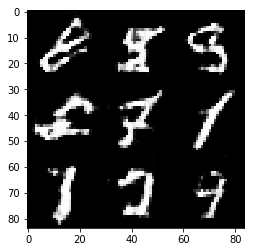

Epoch: 1/2 Iteration: 1810 Discrim. Loss: 1.2864 Generat. Loss: 0.5853
Epoch: 1/2 Iteration: 1820 Discrim. Loss: 1.7358 Generat. Loss: 0.3515
Epoch: 1/2 Iteration: 1830 Discrim. Loss: 2.9477 Generat. Loss: 3.8648
Epoch: 1/2 Iteration: 1840 Discrim. Loss: 1.6313 Generat. Loss: 0.4130
Epoch: 1/2 Iteration: 1850 Discrim. Loss: 1.4805 Generat. Loss: 0.4476
Epoch: 1/2 Iteration: 1860 Discrim. Loss: 1.1570 Generat. Loss: 0.7051
Epoch: 1/2 Iteration: 1870 Discrim. Loss: 0.9238 Generat. Loss: 1.1623
Epoch: 2/2 Iteration: 1880 Discrim. Loss: 0.9517 Generat. Loss: 0.8613
Epoch: 2/2 Iteration: 1890 Discrim. Loss: 2.3203 Generat. Loss: 0.1992
Epoch: 2/2 Iteration: 1900 Discrim. Loss: 1.4372 Generat. Loss: 0.4776


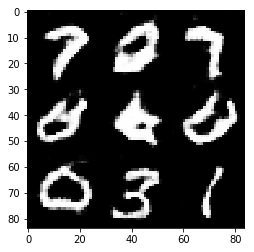

Epoch: 2/2 Iteration: 1910 Discrim. Loss: 1.0674 Generat. Loss: 0.7674
Epoch: 2/2 Iteration: 1920 Discrim. Loss: 0.9279 Generat. Loss: 0.8816
Epoch: 2/2 Iteration: 1930 Discrim. Loss: 1.2956 Generat. Loss: 0.5811
Epoch: 2/2 Iteration: 1940 Discrim. Loss: 1.4448 Generat. Loss: 0.5596
Epoch: 2/2 Iteration: 1950 Discrim. Loss: 1.0471 Generat. Loss: 0.8244
Epoch: 2/2 Iteration: 1960 Discrim. Loss: 1.2096 Generat. Loss: 0.6016
Epoch: 2/2 Iteration: 1970 Discrim. Loss: 1.1979 Generat. Loss: 0.6127
Epoch: 2/2 Iteration: 1980 Discrim. Loss: 3.9009 Generat. Loss: 4.9332
Epoch: 2/2 Iteration: 1990 Discrim. Loss: 0.9486 Generat. Loss: 1.0314
Epoch: 2/2 Iteration: 2000 Discrim. Loss: 1.0165 Generat. Loss: 0.9474


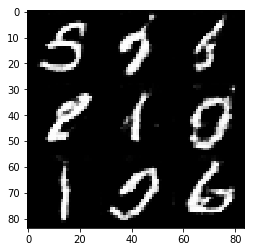

Epoch: 2/2 Iteration: 2010 Discrim. Loss: 1.3553 Generat. Loss: 0.4934
Epoch: 2/2 Iteration: 2020 Discrim. Loss: 1.1251 Generat. Loss: 0.6728
Epoch: 2/2 Iteration: 2030 Discrim. Loss: 1.2746 Generat. Loss: 0.5652
Epoch: 2/2 Iteration: 2040 Discrim. Loss: 1.2256 Generat. Loss: 0.6271
Epoch: 2/2 Iteration: 2050 Discrim. Loss: 1.0017 Generat. Loss: 1.0664
Epoch: 2/2 Iteration: 2060 Discrim. Loss: 1.1804 Generat. Loss: 0.6732
Epoch: 2/2 Iteration: 2070 Discrim. Loss: 1.0524 Generat. Loss: 0.7702
Epoch: 2/2 Iteration: 2080 Discrim. Loss: 1.1030 Generat. Loss: 0.7223
Epoch: 2/2 Iteration: 2090 Discrim. Loss: 1.3791 Generat. Loss: 0.5403
Epoch: 2/2 Iteration: 2100 Discrim. Loss: 1.3371 Generat. Loss: 0.5315


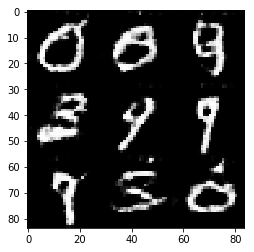

Epoch: 2/2 Iteration: 2110 Discrim. Loss: 0.9961 Generat. Loss: 0.8983
Epoch: 2/2 Iteration: 2120 Discrim. Loss: 1.3348 Generat. Loss: 0.5376
Epoch: 2/2 Iteration: 2130 Discrim. Loss: 0.9273 Generat. Loss: 0.8607
Epoch: 2/2 Iteration: 2140 Discrim. Loss: 1.2036 Generat. Loss: 0.5970
Epoch: 2/2 Iteration: 2150 Discrim. Loss: 4.9399 Generat. Loss: 6.6935
Epoch: 2/2 Iteration: 2160 Discrim. Loss: 0.9793 Generat. Loss: 1.0457
Epoch: 2/2 Iteration: 2170 Discrim. Loss: 1.0483 Generat. Loss: 1.4245
Epoch: 2/2 Iteration: 2180 Discrim. Loss: 0.9803 Generat. Loss: 0.8742
Epoch: 2/2 Iteration: 2190 Discrim. Loss: 1.1713 Generat. Loss: 0.6925
Epoch: 2/2 Iteration: 2200 Discrim. Loss: 1.6716 Generat. Loss: 0.3757


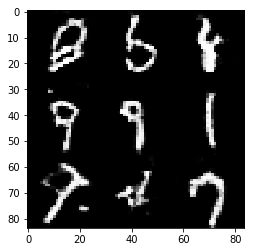

Epoch: 2/2 Iteration: 2210 Discrim. Loss: 1.5525 Generat. Loss: 0.4275
Epoch: 2/2 Iteration: 2220 Discrim. Loss: 1.1576 Generat. Loss: 0.7204
Epoch: 2/2 Iteration: 2230 Discrim. Loss: 1.7614 Generat. Loss: 0.3603
Epoch: 2/2 Iteration: 2240 Discrim. Loss: 0.9459 Generat. Loss: 1.4571
Epoch: 2/2 Iteration: 2250 Discrim. Loss: 1.0888 Generat. Loss: 0.7126
Epoch: 2/2 Iteration: 2260 Discrim. Loss: 1.7474 Generat. Loss: 0.3328
Epoch: 2/2 Iteration: 2270 Discrim. Loss: 0.9132 Generat. Loss: 1.0430
Epoch: 2/2 Iteration: 2280 Discrim. Loss: 1.4243 Generat. Loss: 0.4866
Epoch: 2/2 Iteration: 2290 Discrim. Loss: 1.4138 Generat. Loss: 0.5125
Epoch: 2/2 Iteration: 2300 Discrim. Loss: 0.9398 Generat. Loss: 1.0819


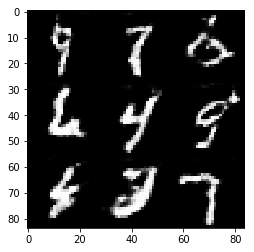

Epoch: 2/2 Iteration: 2310 Discrim. Loss: 1.0364 Generat. Loss: 0.7861
Epoch: 2/2 Iteration: 2320 Discrim. Loss: 0.9974 Generat. Loss: 0.8072
Epoch: 2/2 Iteration: 2330 Discrim. Loss: 0.9728 Generat. Loss: 1.2390
Epoch: 2/2 Iteration: 2340 Discrim. Loss: 0.7396 Generat. Loss: 1.3104
Epoch: 2/2 Iteration: 2350 Discrim. Loss: 1.7580 Generat. Loss: 0.3831
Epoch: 2/2 Iteration: 2360 Discrim. Loss: 1.2291 Generat. Loss: 0.5955
Epoch: 2/2 Iteration: 2370 Discrim. Loss: 1.4437 Generat. Loss: 0.5168
Epoch: 2/2 Iteration: 2380 Discrim. Loss: 1.6253 Generat. Loss: 0.3687
Epoch: 2/2 Iteration: 2390 Discrim. Loss: 0.9090 Generat. Loss: 1.0404
Epoch: 2/2 Iteration: 2400 Discrim. Loss: 1.6264 Generat. Loss: 0.4002


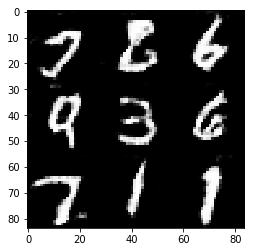

Epoch: 2/2 Iteration: 2410 Discrim. Loss: 1.1513 Generat. Loss: 0.6854
Epoch: 2/2 Iteration: 2420 Discrim. Loss: 1.4306 Generat. Loss: 0.5112
Epoch: 2/2 Iteration: 2430 Discrim. Loss: 1.3250 Generat. Loss: 0.5411
Epoch: 2/2 Iteration: 2440 Discrim. Loss: 0.9546 Generat. Loss: 0.9097
Epoch: 2/2 Iteration: 2450 Discrim. Loss: 1.3933 Generat. Loss: 0.4964
Epoch: 2/2 Iteration: 2460 Discrim. Loss: 1.4291 Generat. Loss: 0.5013
Epoch: 2/2 Iteration: 2470 Discrim. Loss: 1.3605 Generat. Loss: 0.5102
Epoch: 2/2 Iteration: 2480 Discrim. Loss: 1.6458 Generat. Loss: 0.4010
Epoch: 2/2 Iteration: 2490 Discrim. Loss: 1.9137 Generat. Loss: 0.2610
Epoch: 2/2 Iteration: 2500 Discrim. Loss: 1.0890 Generat. Loss: 1.3610


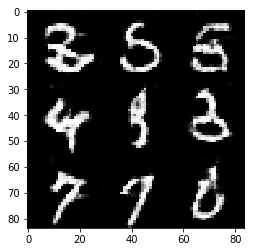

Epoch: 2/2 Iteration: 2510 Discrim. Loss: 1.3241 Generat. Loss: 0.5655
Epoch: 2/2 Iteration: 2520 Discrim. Loss: 1.6536 Generat. Loss: 0.3708
Epoch: 2/2 Iteration: 2530 Discrim. Loss: 1.2659 Generat. Loss: 0.6144
Epoch: 2/2 Iteration: 2540 Discrim. Loss: 1.2506 Generat. Loss: 0.5617
Epoch: 2/2 Iteration: 2550 Discrim. Loss: 1.4653 Generat. Loss: 0.4922
Epoch: 2/2 Iteration: 2560 Discrim. Loss: 0.9604 Generat. Loss: 1.1222
Epoch: 2/2 Iteration: 2570 Discrim. Loss: 1.4721 Generat. Loss: 0.4980
Epoch: 2/2 Iteration: 2580 Discrim. Loss: 1.0931 Generat. Loss: 0.7144
Epoch: 2/2 Iteration: 2590 Discrim. Loss: 2.8816 Generat. Loss: 0.1131
Epoch: 2/2 Iteration: 2600 Discrim. Loss: 1.0095 Generat. Loss: 1.1868


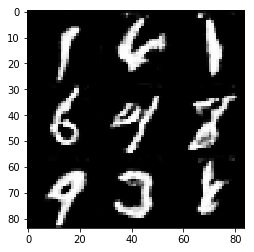

Epoch: 2/2 Iteration: 2610 Discrim. Loss: 0.9576 Generat. Loss: 1.2222
Epoch: 2/2 Iteration: 2620 Discrim. Loss: 1.0380 Generat. Loss: 0.8337
Epoch: 2/2 Iteration: 2630 Discrim. Loss: 0.9912 Generat. Loss: 1.5142
Epoch: 2/2 Iteration: 2640 Discrim. Loss: 1.5265 Generat. Loss: 0.4250
Epoch: 2/2 Iteration: 2650 Discrim. Loss: 1.3642 Generat. Loss: 0.5411
Epoch: 2/2 Iteration: 2660 Discrim. Loss: 1.2509 Generat. Loss: 0.6178
Epoch: 2/2 Iteration: 2670 Discrim. Loss: 0.8699 Generat. Loss: 0.9946
Epoch: 2/2 Iteration: 2680 Discrim. Loss: 1.5211 Generat. Loss: 0.4242
Epoch: 2/2 Iteration: 2690 Discrim. Loss: 1.1996 Generat. Loss: 0.6795
Epoch: 2/2 Iteration: 2700 Discrim. Loss: 1.1126 Generat. Loss: 0.7622


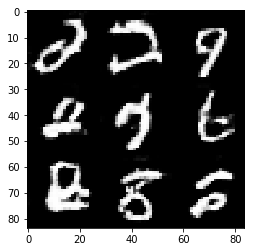

Epoch: 2/2 Iteration: 2710 Discrim. Loss: 1.9026 Generat. Loss: 0.2812
Epoch: 2/2 Iteration: 2720 Discrim. Loss: 0.8068 Generat. Loss: 1.2714
Epoch: 2/2 Iteration: 2730 Discrim. Loss: 1.3465 Generat. Loss: 0.5271
Epoch: 2/2 Iteration: 2740 Discrim. Loss: 1.3842 Generat. Loss: 0.5593
Epoch: 2/2 Iteration: 2750 Discrim. Loss: 1.1380 Generat. Loss: 0.6898
Epoch: 2/2 Iteration: 2760 Discrim. Loss: 0.7081 Generat. Loss: 1.4962
Epoch: 2/2 Iteration: 2770 Discrim. Loss: 1.0243 Generat. Loss: 0.8546
Epoch: 2/2 Iteration: 2780 Discrim. Loss: 1.2479 Generat. Loss: 0.5820
Epoch: 2/2 Iteration: 2790 Discrim. Loss: 1.0616 Generat. Loss: 0.8195
Epoch: 2/2 Iteration: 2800 Discrim. Loss: 1.5411 Generat. Loss: 2.3742


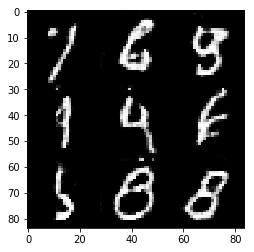

Epoch: 2/2 Iteration: 2810 Discrim. Loss: 0.9388 Generat. Loss: 1.8788
Epoch: 2/2 Iteration: 2820 Discrim. Loss: 1.1235 Generat. Loss: 0.7434
Epoch: 2/2 Iteration: 2830 Discrim. Loss: 0.8843 Generat. Loss: 1.0118
Epoch: 2/2 Iteration: 2840 Discrim. Loss: 1.1889 Generat. Loss: 0.6363
Epoch: 2/2 Iteration: 2850 Discrim. Loss: 1.1487 Generat. Loss: 0.7397
Epoch: 2/2 Iteration: 2860 Discrim. Loss: 1.2981 Generat. Loss: 0.5625
Epoch: 2/2 Iteration: 2870 Discrim. Loss: 0.9990 Generat. Loss: 0.8745
Epoch: 2/2 Iteration: 2880 Discrim. Loss: 1.2658 Generat. Loss: 0.5552
Epoch: 2/2 Iteration: 2890 Discrim. Loss: 1.7586 Generat. Loss: 4.0976
Epoch: 2/2 Iteration: 2900 Discrim. Loss: 1.3385 Generat. Loss: 0.5564


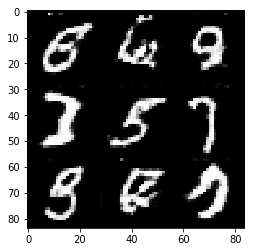

Epoch: 2/2 Iteration: 2910 Discrim. Loss: 1.0996 Generat. Loss: 0.7823
Epoch: 2/2 Iteration: 2920 Discrim. Loss: 0.7913 Generat. Loss: 1.1826
Epoch: 2/2 Iteration: 2930 Discrim. Loss: 1.2567 Generat. Loss: 0.5785
Epoch: 2/2 Iteration: 2940 Discrim. Loss: 1.2296 Generat. Loss: 0.6098
Epoch: 2/2 Iteration: 2950 Discrim. Loss: 1.0572 Generat. Loss: 0.8105
Epoch: 2/2 Iteration: 2960 Discrim. Loss: 0.7381 Generat. Loss: 1.3285
Epoch: 2/2 Iteration: 2970 Discrim. Loss: 1.2381 Generat. Loss: 0.6531
Epoch: 2/2 Iteration: 2980 Discrim. Loss: 1.0782 Generat. Loss: 0.7252
Epoch: 2/2 Iteration: 2990 Discrim. Loss: 0.8391 Generat. Loss: 1.0869
Epoch: 2/2 Iteration: 3000 Discrim. Loss: 1.5653 Generat. Loss: 0.4460


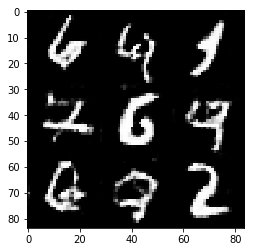

Epoch: 2/2 Iteration: 3010 Discrim. Loss: 1.1023 Generat. Loss: 0.7361
Epoch: 2/2 Iteration: 3020 Discrim. Loss: 1.5585 Generat. Loss: 0.3904
Epoch: 2/2 Iteration: 3030 Discrim. Loss: 0.9813 Generat. Loss: 0.8501
Epoch: 2/2 Iteration: 3040 Discrim. Loss: 1.2668 Generat. Loss: 0.5519
Epoch: 2/2 Iteration: 3050 Discrim. Loss: 1.5466 Generat. Loss: 0.4612
Epoch: 2/2 Iteration: 3060 Discrim. Loss: 0.9886 Generat. Loss: 0.8365
Epoch: 2/2 Iteration: 3070 Discrim. Loss: 1.2538 Generat. Loss: 0.6230
Epoch: 2/2 Iteration: 3080 Discrim. Loss: 1.3441 Generat. Loss: 0.5098
Epoch: 2/2 Iteration: 3090 Discrim. Loss: 0.9749 Generat. Loss: 0.8490
Epoch: 2/2 Iteration: 3100 Discrim. Loss: 1.4037 Generat. Loss: 0.5354


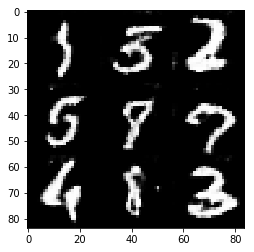

Epoch: 2/2 Iteration: 3110 Discrim. Loss: 1.0096 Generat. Loss: 0.8944
Epoch: 2/2 Iteration: 3120 Discrim. Loss: 1.1332 Generat. Loss: 0.6893
Epoch: 2/2 Iteration: 3130 Discrim. Loss: 0.9044 Generat. Loss: 1.0119
Epoch: 2/2 Iteration: 3140 Discrim. Loss: 0.8232 Generat. Loss: 1.5535
Epoch: 2/2 Iteration: 3150 Discrim. Loss: 1.2161 Generat. Loss: 0.5962
Epoch: 2/2 Iteration: 3160 Discrim. Loss: 1.7403 Generat. Loss: 0.3808
Epoch: 2/2 Iteration: 3170 Discrim. Loss: 0.7618 Generat. Loss: 1.3065
Epoch: 2/2 Iteration: 3180 Discrim. Loss: 0.8076 Generat. Loss: 1.3362
Epoch: 2/2 Iteration: 3190 Discrim. Loss: 1.5605 Generat. Loss: 0.4067
Epoch: 2/2 Iteration: 3200 Discrim. Loss: 1.0560 Generat. Loss: 0.8134


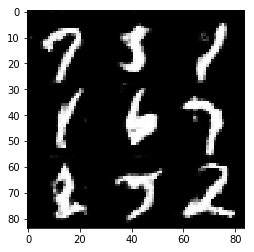

Epoch: 2/2 Iteration: 3210 Discrim. Loss: 2.1026 Generat. Loss: 0.2462
Epoch: 2/2 Iteration: 3220 Discrim. Loss: 0.8525 Generat. Loss: 1.2531
Epoch: 2/2 Iteration: 3230 Discrim. Loss: 1.3618 Generat. Loss: 2.3493
Epoch: 2/2 Iteration: 3240 Discrim. Loss: 1.1239 Generat. Loss: 0.7387
Epoch: 2/2 Iteration: 3250 Discrim. Loss: 1.2015 Generat. Loss: 0.6494
Epoch: 2/2 Iteration: 3260 Discrim. Loss: 1.1016 Generat. Loss: 0.7452
Epoch: 2/2 Iteration: 3270 Discrim. Loss: 0.9540 Generat. Loss: 0.8955
Epoch: 2/2 Iteration: 3280 Discrim. Loss: 1.1727 Generat. Loss: 0.6653
Epoch: 2/2 Iteration: 3290 Discrim. Loss: 1.8806 Generat. Loss: 0.2863
Epoch: 2/2 Iteration: 3300 Discrim. Loss: 1.8702 Generat. Loss: 0.2910


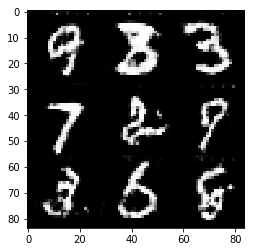

Epoch: 2/2 Iteration: 3310 Discrim. Loss: 1.1021 Generat. Loss: 0.8935
Epoch: 2/2 Iteration: 3320 Discrim. Loss: 1.5367 Generat. Loss: 0.4134
Epoch: 2/2 Iteration: 3330 Discrim. Loss: 0.7877 Generat. Loss: 1.1924
Epoch: 2/2 Iteration: 3340 Discrim. Loss: 1.2770 Generat. Loss: 0.6019
Epoch: 2/2 Iteration: 3350 Discrim. Loss: 1.0504 Generat. Loss: 0.7899
Epoch: 2/2 Iteration: 3360 Discrim. Loss: 1.1622 Generat. Loss: 0.6706
Epoch: 2/2 Iteration: 3370 Discrim. Loss: 1.0087 Generat. Loss: 0.8112
Epoch: 2/2 Iteration: 3380 Discrim. Loss: 0.6768 Generat. Loss: 1.3616
Epoch: 2/2 Iteration: 3390 Discrim. Loss: 1.2809 Generat. Loss: 0.5637
Epoch: 2/2 Iteration: 3400 Discrim. Loss: 0.7818 Generat. Loss: 1.1830


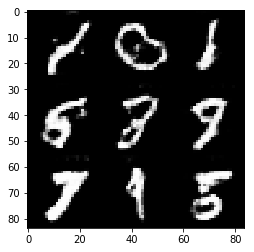

Epoch: 2/2 Iteration: 3410 Discrim. Loss: 0.9049 Generat. Loss: 1.0074
Epoch: 2/2 Iteration: 3420 Discrim. Loss: 1.6252 Generat. Loss: 0.4013
Epoch: 2/2 Iteration: 3430 Discrim. Loss: 0.9037 Generat. Loss: 1.0978
Epoch: 2/2 Iteration: 3440 Discrim. Loss: 1.4767 Generat. Loss: 0.4527
Epoch: 2/2 Iteration: 3450 Discrim. Loss: 1.1350 Generat. Loss: 0.9837
Epoch: 2/2 Iteration: 3460 Discrim. Loss: 2.0033 Generat. Loss: 0.2968
Epoch: 2/2 Iteration: 3470 Discrim. Loss: 1.5293 Generat. Loss: 0.4567
Epoch: 2/2 Iteration: 3480 Discrim. Loss: 0.9035 Generat. Loss: 1.1500
Epoch: 2/2 Iteration: 3490 Discrim. Loss: 1.1015 Generat. Loss: 0.7383
Epoch: 2/2 Iteration: 3500 Discrim. Loss: 1.7899 Generat. Loss: 0.3703


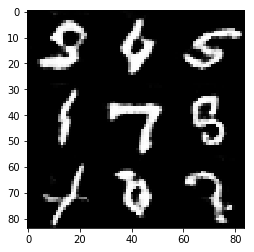

Epoch: 2/2 Iteration: 3510 Discrim. Loss: 0.8545 Generat. Loss: 1.1480
Epoch: 2/2 Iteration: 3520 Discrim. Loss: 1.4047 Generat. Loss: 0.5847
Epoch: 2/2 Iteration: 3530 Discrim. Loss: 0.8311 Generat. Loss: 1.0773
Epoch: 2/2 Iteration: 3540 Discrim. Loss: 1.2050 Generat. Loss: 0.6174
Epoch: 2/2 Iteration: 3550 Discrim. Loss: 1.0672 Generat. Loss: 0.7219
Epoch: 2/2 Iteration: 3560 Discrim. Loss: 1.0670 Generat. Loss: 0.7784
Epoch: 2/2 Iteration: 3570 Discrim. Loss: 1.4463 Generat. Loss: 0.4596
Epoch: 2/2 Iteration: 3580 Discrim. Loss: 1.7611 Generat. Loss: 0.3423
Epoch: 2/2 Iteration: 3590 Discrim. Loss: 1.3223 Generat. Loss: 0.5405
Epoch: 2/2 Iteration: 3600 Discrim. Loss: 1.1167 Generat. Loss: 0.7118


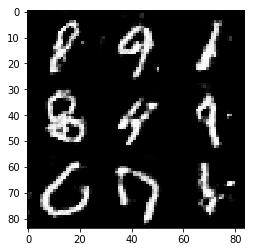

Epoch: 2/2 Iteration: 3610 Discrim. Loss: 0.8233 Generat. Loss: 1.1542
Epoch: 2/2 Iteration: 3620 Discrim. Loss: 1.2668 Generat. Loss: 0.5933
Epoch: 2/2 Iteration: 3630 Discrim. Loss: 1.1155 Generat. Loss: 0.7190
Epoch: 2/2 Iteration: 3640 Discrim. Loss: 1.4894 Generat. Loss: 0.4659
Epoch: 2/2 Iteration: 3650 Discrim. Loss: 0.8036 Generat. Loss: 1.1800
Epoch: 2/2 Iteration: 3660 Discrim. Loss: 1.2157 Generat. Loss: 0.6290
Epoch: 2/2 Iteration: 3670 Discrim. Loss: 0.8664 Generat. Loss: 1.3204
Epoch: 2/2 Iteration: 3680 Discrim. Loss: 1.5049 Generat. Loss: 0.4564
Epoch: 2/2 Iteration: 3690 Discrim. Loss: 1.6673 Generat. Loss: 0.4167
Epoch: 2/2 Iteration: 3700 Discrim. Loss: 1.8161 Generat. Loss: 0.3764


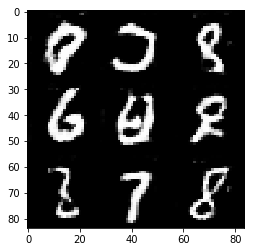

Epoch: 2/2 Iteration: 3710 Discrim. Loss: 0.8310 Generat. Loss: 1.1913
Epoch: 2/2 Iteration: 3720 Discrim. Loss: 0.8410 Generat. Loss: 1.0710
Epoch: 2/2 Iteration: 3730 Discrim. Loss: 1.8752 Generat. Loss: 0.3090
Epoch: 2/2 Iteration: 3740 Discrim. Loss: 0.9779 Generat. Loss: 0.9001
Epoch: 2/2 Iteration: 3750 Discrim. Loss: 0.9493 Generat. Loss: 0.9522


In [34]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch: 1/1 Iteration: 10 Discrim. Loss: 4.1183 Generat. Loss: 0.0326
Epoch: 1/1 Iteration: 20 Discrim. Loss: 3.7400 Generat. Loss: 0.0479
Epoch: 1/1 Iteration: 30 Discrim. Loss: 3.0762 Generat. Loss: 0.1335
Epoch: 1/1 Iteration: 40 Discrim. Loss: 1.4971 Generat. Loss: 5.6310
Epoch: 1/1 Iteration: 50 Discrim. Loss: 1.6054 Generat. Loss: 0.3801
Epoch: 1/1 Iteration: 60 Discrim. Loss: 0.8509 Generat. Loss: 1.3546
Epoch: 1/1 Iteration: 70 Discrim. Loss: 0.5963 Generat. Loss: 2.4460
Epoch: 1/1 Iteration: 80 Discrim. Loss: 0.8009 Generat. Loss: 1.2697
Epoch: 1/1 Iteration: 90 Discrim. Loss: 1.4488 Generat. Loss: 0.5397
Epoch: 1/1 Iteration: 100 Discrim. Loss: 1.3349 Generat. Loss: 0.6565


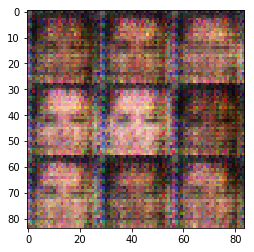

Epoch: 1/1 Iteration: 110 Discrim. Loss: 1.1596 Generat. Loss: 2.2232
Epoch: 1/1 Iteration: 120 Discrim. Loss: 1.6818 Generat. Loss: 0.4150
Epoch: 1/1 Iteration: 130 Discrim. Loss: 1.6637 Generat. Loss: 0.4025
Epoch: 1/1 Iteration: 140 Discrim. Loss: 1.5184 Generat. Loss: 0.5979
Epoch: 1/1 Iteration: 150 Discrim. Loss: 0.9726 Generat. Loss: 1.3776
Epoch: 1/1 Iteration: 160 Discrim. Loss: 1.3829 Generat. Loss: 2.8137
Epoch: 1/1 Iteration: 170 Discrim. Loss: 1.2232 Generat. Loss: 1.3087
Epoch: 1/1 Iteration: 180 Discrim. Loss: 1.0869 Generat. Loss: 1.2974
Epoch: 1/1 Iteration: 190 Discrim. Loss: 1.1656 Generat. Loss: 0.7565
Epoch: 1/1 Iteration: 200 Discrim. Loss: 1.4206 Generat. Loss: 2.5124


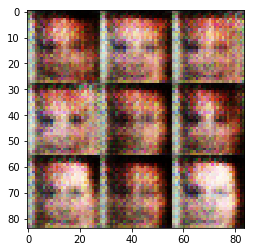

Epoch: 1/1 Iteration: 210 Discrim. Loss: 1.2575 Generat. Loss: 0.7456
Epoch: 1/1 Iteration: 220 Discrim. Loss: 1.5777 Generat. Loss: 0.4571
Epoch: 1/1 Iteration: 230 Discrim. Loss: 1.4299 Generat. Loss: 0.5322
Epoch: 1/1 Iteration: 240 Discrim. Loss: 1.4026 Generat. Loss: 0.6502
Epoch: 1/1 Iteration: 250 Discrim. Loss: 1.5829 Generat. Loss: 0.4415
Epoch: 1/1 Iteration: 260 Discrim. Loss: 1.5001 Generat. Loss: 0.4757
Epoch: 1/1 Iteration: 270 Discrim. Loss: 1.4555 Generat. Loss: 1.4042
Epoch: 1/1 Iteration: 280 Discrim. Loss: 1.5228 Generat. Loss: 0.5817
Epoch: 1/1 Iteration: 290 Discrim. Loss: 1.7516 Generat. Loss: 0.3156
Epoch: 1/1 Iteration: 300 Discrim. Loss: 1.4069 Generat. Loss: 0.6266


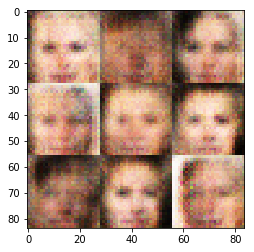

Epoch: 1/1 Iteration: 310 Discrim. Loss: 1.5718 Generat. Loss: 0.9124
Epoch: 1/1 Iteration: 320 Discrim. Loss: 1.6277 Generat. Loss: 0.5132
Epoch: 1/1 Iteration: 330 Discrim. Loss: 1.4672 Generat. Loss: 0.5018
Epoch: 1/1 Iteration: 340 Discrim. Loss: 1.6547 Generat. Loss: 0.4258
Epoch: 1/1 Iteration: 350 Discrim. Loss: 1.3819 Generat. Loss: 0.8844
Epoch: 1/1 Iteration: 360 Discrim. Loss: 1.6075 Generat. Loss: 0.4211
Epoch: 1/1 Iteration: 370 Discrim. Loss: 1.3404 Generat. Loss: 1.2099
Epoch: 1/1 Iteration: 380 Discrim. Loss: 1.3955 Generat. Loss: 1.0920
Epoch: 1/1 Iteration: 390 Discrim. Loss: 1.4596 Generat. Loss: 1.1846
Epoch: 1/1 Iteration: 400 Discrim. Loss: 1.6861 Generat. Loss: 0.5621


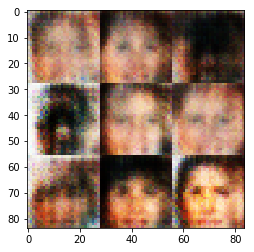

Epoch: 1/1 Iteration: 410 Discrim. Loss: 1.4753 Generat. Loss: 0.8485
Epoch: 1/1 Iteration: 420 Discrim. Loss: 1.5085 Generat. Loss: 0.7913
Epoch: 1/1 Iteration: 430 Discrim. Loss: 1.4244 Generat. Loss: 0.5332
Epoch: 1/1 Iteration: 440 Discrim. Loss: 1.5294 Generat. Loss: 0.7895
Epoch: 1/1 Iteration: 450 Discrim. Loss: 1.5261 Generat. Loss: 0.5184
Epoch: 1/1 Iteration: 460 Discrim. Loss: 1.4662 Generat. Loss: 0.5511
Epoch: 1/1 Iteration: 470 Discrim. Loss: 1.4727 Generat. Loss: 0.7237
Epoch: 1/1 Iteration: 480 Discrim. Loss: 1.4730 Generat. Loss: 1.3251
Epoch: 1/1 Iteration: 490 Discrim. Loss: 1.4026 Generat. Loss: 0.6059
Epoch: 1/1 Iteration: 500 Discrim. Loss: 1.3915 Generat. Loss: 0.6903


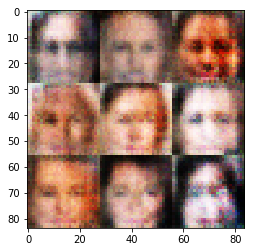

Epoch: 1/1 Iteration: 510 Discrim. Loss: 1.6019 Generat. Loss: 0.6725
Epoch: 1/1 Iteration: 520 Discrim. Loss: 1.3873 Generat. Loss: 0.7021
Epoch: 1/1 Iteration: 530 Discrim. Loss: 1.7250 Generat. Loss: 0.4232
Epoch: 1/1 Iteration: 540 Discrim. Loss: 1.5488 Generat. Loss: 0.6151
Epoch: 1/1 Iteration: 550 Discrim. Loss: 1.4124 Generat. Loss: 0.7294
Epoch: 1/1 Iteration: 560 Discrim. Loss: 1.3380 Generat. Loss: 0.8570
Epoch: 1/1 Iteration: 570 Discrim. Loss: 1.5615 Generat. Loss: 0.4326
Epoch: 1/1 Iteration: 580 Discrim. Loss: 1.4612 Generat. Loss: 0.9431
Epoch: 1/1 Iteration: 590 Discrim. Loss: 1.4921 Generat. Loss: 0.5167
Epoch: 1/1 Iteration: 600 Discrim. Loss: 1.7025 Generat. Loss: 0.4246


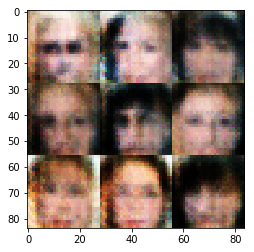

Epoch: 1/1 Iteration: 610 Discrim. Loss: 1.6803 Generat. Loss: 0.4476
Epoch: 1/1 Iteration: 620 Discrim. Loss: 1.6516 Generat. Loss: 0.4009
Epoch: 1/1 Iteration: 630 Discrim. Loss: 1.5803 Generat. Loss: 0.4377
Epoch: 1/1 Iteration: 640 Discrim. Loss: 1.4499 Generat. Loss: 0.7923
Epoch: 1/1 Iteration: 650 Discrim. Loss: 1.5276 Generat. Loss: 0.6206
Epoch: 1/1 Iteration: 660 Discrim. Loss: 1.6051 Generat. Loss: 0.9163
Epoch: 1/1 Iteration: 670 Discrim. Loss: 1.6047 Generat. Loss: 0.4313
Epoch: 1/1 Iteration: 680 Discrim. Loss: 1.8648 Generat. Loss: 0.3103
Epoch: 1/1 Iteration: 690 Discrim. Loss: 1.4120 Generat. Loss: 0.6446
Epoch: 1/1 Iteration: 700 Discrim. Loss: 1.4524 Generat. Loss: 0.6373


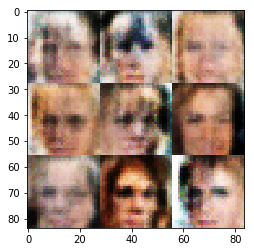

Epoch: 1/1 Iteration: 710 Discrim. Loss: 1.3300 Generat. Loss: 0.6346
Epoch: 1/1 Iteration: 720 Discrim. Loss: 1.5678 Generat. Loss: 0.7185
Epoch: 1/1 Iteration: 730 Discrim. Loss: 1.3672 Generat. Loss: 0.8247
Epoch: 1/1 Iteration: 740 Discrim. Loss: 1.7042 Generat. Loss: 0.3654
Epoch: 1/1 Iteration: 750 Discrim. Loss: 1.4899 Generat. Loss: 1.0369
Epoch: 1/1 Iteration: 760 Discrim. Loss: 1.3737 Generat. Loss: 0.9091
Epoch: 1/1 Iteration: 770 Discrim. Loss: 1.6177 Generat. Loss: 0.4500
Epoch: 1/1 Iteration: 780 Discrim. Loss: 1.5965 Generat. Loss: 0.4236
Epoch: 1/1 Iteration: 790 Discrim. Loss: 1.3987 Generat. Loss: 0.6146
Epoch: 1/1 Iteration: 800 Discrim. Loss: 1.5103 Generat. Loss: 0.5431


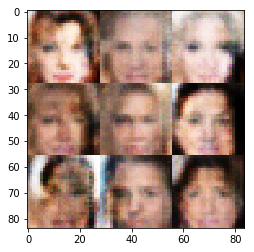

Epoch: 1/1 Iteration: 810 Discrim. Loss: 1.4590 Generat. Loss: 0.6479
Epoch: 1/1 Iteration: 820 Discrim. Loss: 1.5426 Generat. Loss: 0.7529
Epoch: 1/1 Iteration: 830 Discrim. Loss: 1.6434 Generat. Loss: 0.3713
Epoch: 1/1 Iteration: 840 Discrim. Loss: 1.5555 Generat. Loss: 0.6371
Epoch: 1/1 Iteration: 850 Discrim. Loss: 1.6510 Generat. Loss: 0.3861
Epoch: 1/1 Iteration: 860 Discrim. Loss: 1.6742 Generat. Loss: 0.4261
Epoch: 1/1 Iteration: 870 Discrim. Loss: 1.4110 Generat. Loss: 0.5362
Epoch: 1/1 Iteration: 880 Discrim. Loss: 1.4365 Generat. Loss: 0.7143
Epoch: 1/1 Iteration: 890 Discrim. Loss: 1.6142 Generat. Loss: 0.4329
Epoch: 1/1 Iteration: 900 Discrim. Loss: 1.5553 Generat. Loss: 0.7137


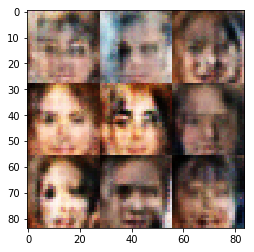

Epoch: 1/1 Iteration: 910 Discrim. Loss: 1.6222 Generat. Loss: 0.4787
Epoch: 1/1 Iteration: 920 Discrim. Loss: 1.5067 Generat. Loss: 0.9351
Epoch: 1/1 Iteration: 930 Discrim. Loss: 1.4641 Generat. Loss: 0.4956
Epoch: 1/1 Iteration: 940 Discrim. Loss: 1.4010 Generat. Loss: 0.6988
Epoch: 1/1 Iteration: 950 Discrim. Loss: 1.6267 Generat. Loss: 0.6161
Epoch: 1/1 Iteration: 960 Discrim. Loss: 1.6177 Generat. Loss: 0.5410
Epoch: 1/1 Iteration: 970 Discrim. Loss: 1.2940 Generat. Loss: 0.8492
Epoch: 1/1 Iteration: 980 Discrim. Loss: 1.7529 Generat. Loss: 0.4000
Epoch: 1/1 Iteration: 990 Discrim. Loss: 1.3202 Generat. Loss: 0.7798
Epoch: 1/1 Iteration: 1000 Discrim. Loss: 1.4315 Generat. Loss: 0.7042


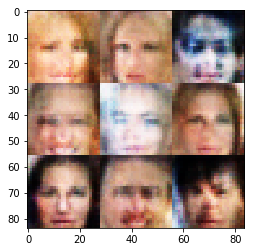

Epoch: 1/1 Iteration: 1010 Discrim. Loss: 1.4357 Generat. Loss: 0.6549
Epoch: 1/1 Iteration: 1020 Discrim. Loss: 1.6283 Generat. Loss: 0.3849
Epoch: 1/1 Iteration: 1030 Discrim. Loss: 1.4978 Generat. Loss: 0.4456
Epoch: 1/1 Iteration: 1040 Discrim. Loss: 1.8271 Generat. Loss: 0.3560
Epoch: 1/1 Iteration: 1050 Discrim. Loss: 1.8805 Generat. Loss: 0.2786
Epoch: 1/1 Iteration: 1060 Discrim. Loss: 1.6894 Generat. Loss: 0.5312
Epoch: 1/1 Iteration: 1070 Discrim. Loss: 1.5266 Generat. Loss: 0.5668
Epoch: 1/1 Iteration: 1080 Discrim. Loss: 1.4463 Generat. Loss: 0.6782
Epoch: 1/1 Iteration: 1090 Discrim. Loss: 1.6723 Generat. Loss: 0.5606
Epoch: 1/1 Iteration: 1100 Discrim. Loss: 1.5693 Generat. Loss: 0.5737


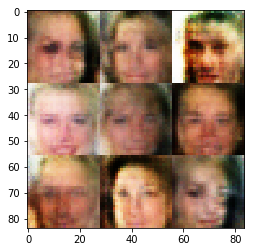

Epoch: 1/1 Iteration: 1110 Discrim. Loss: 1.6137 Generat. Loss: 0.4346
Epoch: 1/1 Iteration: 1120 Discrim. Loss: 1.8910 Generat. Loss: 0.2673
Epoch: 1/1 Iteration: 1130 Discrim. Loss: 1.7693 Generat. Loss: 0.3197
Epoch: 1/1 Iteration: 1140 Discrim. Loss: 1.5360 Generat. Loss: 0.5774
Epoch: 1/1 Iteration: 1150 Discrim. Loss: 1.5166 Generat. Loss: 0.5399
Epoch: 1/1 Iteration: 1160 Discrim. Loss: 1.5287 Generat. Loss: 0.8414
Epoch: 1/1 Iteration: 1170 Discrim. Loss: 1.3563 Generat. Loss: 0.6075
Epoch: 1/1 Iteration: 1180 Discrim. Loss: 1.5383 Generat. Loss: 0.5835
Epoch: 1/1 Iteration: 1190 Discrim. Loss: 1.8257 Generat. Loss: 0.3146
Epoch: 1/1 Iteration: 1200 Discrim. Loss: 1.8972 Generat. Loss: 0.2851


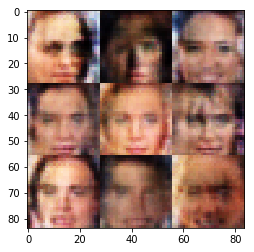

Epoch: 1/1 Iteration: 1210 Discrim. Loss: 1.6586 Generat. Loss: 0.4524
Epoch: 1/1 Iteration: 1220 Discrim. Loss: 1.5999 Generat. Loss: 0.4758
Epoch: 1/1 Iteration: 1230 Discrim. Loss: 1.9450 Generat. Loss: 0.2695
Epoch: 1/1 Iteration: 1240 Discrim. Loss: 1.1666 Generat. Loss: 0.8997
Epoch: 1/1 Iteration: 1250 Discrim. Loss: 1.7090 Generat. Loss: 0.9525
Epoch: 1/1 Iteration: 1260 Discrim. Loss: 1.8220 Generat. Loss: 0.4436
Epoch: 1/1 Iteration: 1270 Discrim. Loss: 1.6709 Generat. Loss: 0.5260
Epoch: 1/1 Iteration: 1280 Discrim. Loss: 1.5442 Generat. Loss: 0.6165
Epoch: 1/1 Iteration: 1290 Discrim. Loss: 1.9537 Generat. Loss: 0.2791
Epoch: 1/1 Iteration: 1300 Discrim. Loss: 1.4304 Generat. Loss: 0.6328


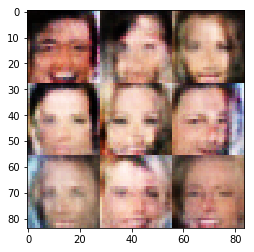

Epoch: 1/1 Iteration: 1310 Discrim. Loss: 1.8370 Generat. Loss: 0.3168
Epoch: 1/1 Iteration: 1320 Discrim. Loss: 1.5614 Generat. Loss: 0.4143
Epoch: 1/1 Iteration: 1330 Discrim. Loss: 1.7536 Generat. Loss: 0.4198
Epoch: 1/1 Iteration: 1340 Discrim. Loss: 1.8087 Generat. Loss: 0.3184
Epoch: 1/1 Iteration: 1350 Discrim. Loss: 1.9517 Generat. Loss: 0.3289
Epoch: 1/1 Iteration: 1360 Discrim. Loss: 1.5752 Generat. Loss: 0.7330
Epoch: 1/1 Iteration: 1370 Discrim. Loss: 1.6749 Generat. Loss: 0.3700
Epoch: 1/1 Iteration: 1380 Discrim. Loss: 1.4018 Generat. Loss: 0.4985
Epoch: 1/1 Iteration: 1390 Discrim. Loss: 1.8531 Generat. Loss: 0.3413
Epoch: 1/1 Iteration: 1400 Discrim. Loss: 1.6173 Generat. Loss: 0.3988


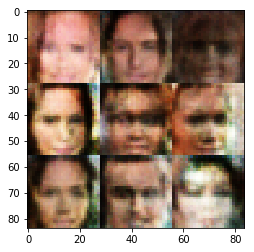

Epoch: 1/1 Iteration: 1410 Discrim. Loss: 1.8665 Generat. Loss: 0.2916
Epoch: 1/1 Iteration: 1420 Discrim. Loss: 1.9187 Generat. Loss: 0.2757
Epoch: 1/1 Iteration: 1430 Discrim. Loss: 1.7015 Generat. Loss: 0.3654
Epoch: 1/1 Iteration: 1440 Discrim. Loss: 1.8826 Generat. Loss: 0.2939
Epoch: 1/1 Iteration: 1450 Discrim. Loss: 1.3703 Generat. Loss: 0.7731
Epoch: 1/1 Iteration: 1460 Discrim. Loss: 1.9374 Generat. Loss: 0.2806
Epoch: 1/1 Iteration: 1470 Discrim. Loss: 1.4132 Generat. Loss: 0.8231
Epoch: 1/1 Iteration: 1480 Discrim. Loss: 1.9379 Generat. Loss: 0.2486
Epoch: 1/1 Iteration: 1490 Discrim. Loss: 1.7232 Generat. Loss: 0.3367
Epoch: 1/1 Iteration: 1500 Discrim. Loss: 1.6854 Generat. Loss: 0.5817


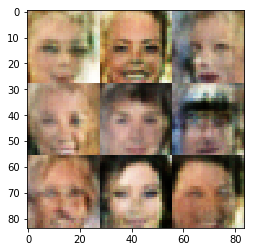

Epoch: 1/1 Iteration: 1510 Discrim. Loss: 1.7543 Generat. Loss: 0.3425
Epoch: 1/1 Iteration: 1520 Discrim. Loss: 1.5544 Generat. Loss: 0.4665
Epoch: 1/1 Iteration: 1530 Discrim. Loss: 1.7875 Generat. Loss: 0.2942
Epoch: 1/1 Iteration: 1540 Discrim. Loss: 1.6858 Generat. Loss: 0.3922
Epoch: 1/1 Iteration: 1550 Discrim. Loss: 1.6100 Generat. Loss: 0.4644
Epoch: 1/1 Iteration: 1560 Discrim. Loss: 1.4153 Generat. Loss: 1.1172
Epoch: 1/1 Iteration: 1570 Discrim. Loss: 1.5181 Generat. Loss: 0.5613
Epoch: 1/1 Iteration: 1580 Discrim. Loss: 1.6847 Generat. Loss: 0.4042
Epoch: 1/1 Iteration: 1590 Discrim. Loss: 1.3682 Generat. Loss: 0.6827
Epoch: 1/1 Iteration: 1600 Discrim. Loss: 1.8478 Generat. Loss: 0.3012


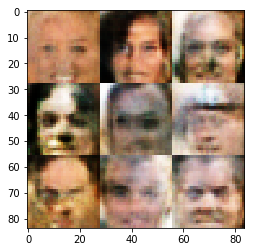

Epoch: 1/1 Iteration: 1610 Discrim. Loss: 1.4759 Generat. Loss: 0.5797
Epoch: 1/1 Iteration: 1620 Discrim. Loss: 1.6014 Generat. Loss: 0.3929
Epoch: 1/1 Iteration: 1630 Discrim. Loss: 1.9510 Generat. Loss: 0.2892
Epoch: 1/1 Iteration: 1640 Discrim. Loss: 1.6660 Generat. Loss: 0.3787
Epoch: 1/1 Iteration: 1650 Discrim. Loss: 1.7705 Generat. Loss: 0.4830
Epoch: 1/1 Iteration: 1660 Discrim. Loss: 1.5627 Generat. Loss: 0.5094
Epoch: 1/1 Iteration: 1670 Discrim. Loss: 1.4131 Generat. Loss: 0.6152
Epoch: 1/1 Iteration: 1680 Discrim. Loss: 1.4650 Generat. Loss: 0.5334
Epoch: 1/1 Iteration: 1690 Discrim. Loss: 1.6106 Generat. Loss: 0.6304
Epoch: 1/1 Iteration: 1700 Discrim. Loss: 1.8139 Generat. Loss: 0.3223


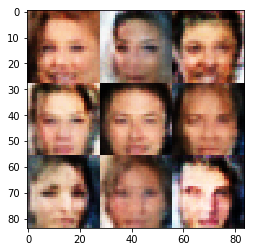

Epoch: 1/1 Iteration: 1710 Discrim. Loss: 1.5572 Generat. Loss: 0.5371
Epoch: 1/1 Iteration: 1720 Discrim. Loss: 1.8355 Generat. Loss: 0.2773
Epoch: 1/1 Iteration: 1730 Discrim. Loss: 1.4498 Generat. Loss: 0.8741
Epoch: 1/1 Iteration: 1740 Discrim. Loss: 1.4806 Generat. Loss: 0.6140
Epoch: 1/1 Iteration: 1750 Discrim. Loss: 1.5945 Generat. Loss: 0.4378
Epoch: 1/1 Iteration: 1760 Discrim. Loss: 1.5292 Generat. Loss: 0.4530
Epoch: 1/1 Iteration: 1770 Discrim. Loss: 1.5845 Generat. Loss: 0.4588
Epoch: 1/1 Iteration: 1780 Discrim. Loss: 1.5934 Generat. Loss: 0.4783
Epoch: 1/1 Iteration: 1790 Discrim. Loss: 1.4585 Generat. Loss: 0.4817
Epoch: 1/1 Iteration: 1800 Discrim. Loss: 1.8646 Generat. Loss: 0.3493


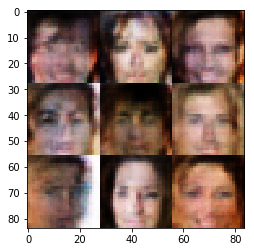

Epoch: 1/1 Iteration: 1810 Discrim. Loss: 1.6271 Generat. Loss: 0.5488
Epoch: 1/1 Iteration: 1820 Discrim. Loss: 1.6573 Generat. Loss: 0.3977
Epoch: 1/1 Iteration: 1830 Discrim. Loss: 1.8602 Generat. Loss: 0.3065
Epoch: 1/1 Iteration: 1840 Discrim. Loss: 1.8735 Generat. Loss: 0.2778
Epoch: 1/1 Iteration: 1850 Discrim. Loss: 1.3647 Generat. Loss: 0.7712
Epoch: 1/1 Iteration: 1860 Discrim. Loss: 1.7224 Generat. Loss: 0.3914
Epoch: 1/1 Iteration: 1870 Discrim. Loss: 1.7249 Generat. Loss: 0.4226
Epoch: 1/1 Iteration: 1880 Discrim. Loss: 1.8524 Generat. Loss: 0.4100
Epoch: 1/1 Iteration: 1890 Discrim. Loss: 1.6995 Generat. Loss: 0.3806
Epoch: 1/1 Iteration: 1900 Discrim. Loss: 1.4840 Generat. Loss: 0.6070


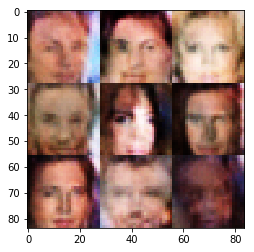

Epoch: 1/1 Iteration: 1910 Discrim. Loss: 1.6555 Generat. Loss: 0.6789
Epoch: 1/1 Iteration: 1920 Discrim. Loss: 1.5170 Generat. Loss: 0.4744
Epoch: 1/1 Iteration: 1930 Discrim. Loss: 1.3175 Generat. Loss: 0.6258
Epoch: 1/1 Iteration: 1940 Discrim. Loss: 1.5864 Generat. Loss: 0.4643
Epoch: 1/1 Iteration: 1950 Discrim. Loss: 1.5488 Generat. Loss: 0.5235
Epoch: 1/1 Iteration: 1960 Discrim. Loss: 1.3379 Generat. Loss: 0.7346
Epoch: 1/1 Iteration: 1970 Discrim. Loss: 1.9071 Generat. Loss: 0.2656
Epoch: 1/1 Iteration: 1980 Discrim. Loss: 1.7586 Generat. Loss: 0.3508
Epoch: 1/1 Iteration: 1990 Discrim. Loss: 1.6735 Generat. Loss: 0.3438
Epoch: 1/1 Iteration: 2000 Discrim. Loss: 1.8718 Generat. Loss: 0.2857


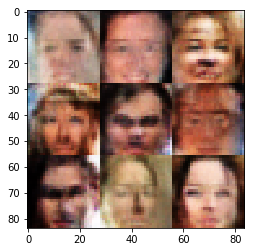

Epoch: 1/1 Iteration: 2010 Discrim. Loss: 1.5833 Generat. Loss: 0.4057
Epoch: 1/1 Iteration: 2020 Discrim. Loss: 1.7642 Generat. Loss: 0.3278
Epoch: 1/1 Iteration: 2030 Discrim. Loss: 1.4463 Generat. Loss: 0.6179
Epoch: 1/1 Iteration: 2040 Discrim. Loss: 1.8482 Generat. Loss: 0.2882
Epoch: 1/1 Iteration: 2050 Discrim. Loss: 1.6686 Generat. Loss: 0.3819
Epoch: 1/1 Iteration: 2060 Discrim. Loss: 1.6619 Generat. Loss: 0.4908
Epoch: 1/1 Iteration: 2070 Discrim. Loss: 1.4042 Generat. Loss: 0.6129
Epoch: 1/1 Iteration: 2080 Discrim. Loss: 2.1281 Generat. Loss: 0.2156
Epoch: 1/1 Iteration: 2090 Discrim. Loss: 1.7348 Generat. Loss: 0.3471
Epoch: 1/1 Iteration: 2100 Discrim. Loss: 1.5571 Generat. Loss: 0.4473


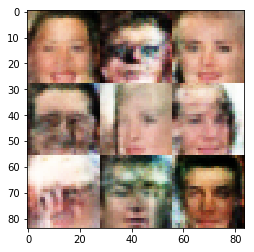

Epoch: 1/1 Iteration: 2110 Discrim. Loss: 1.5015 Generat. Loss: 0.5502
Epoch: 1/1 Iteration: 2120 Discrim. Loss: 1.9755 Generat. Loss: 0.3499
Epoch: 1/1 Iteration: 2130 Discrim. Loss: 1.5204 Generat. Loss: 0.5180
Epoch: 1/1 Iteration: 2140 Discrim. Loss: 1.6951 Generat. Loss: 0.3644
Epoch: 1/1 Iteration: 2150 Discrim. Loss: 1.5548 Generat. Loss: 0.5274
Epoch: 1/1 Iteration: 2160 Discrim. Loss: 1.7743 Generat. Loss: 0.3127
Epoch: 1/1 Iteration: 2170 Discrim. Loss: 1.9417 Generat. Loss: 0.2513
Epoch: 1/1 Iteration: 2180 Discrim. Loss: 1.8870 Generat. Loss: 0.2648
Epoch: 1/1 Iteration: 2190 Discrim. Loss: 1.6821 Generat. Loss: 0.7825
Epoch: 1/1 Iteration: 2200 Discrim. Loss: 1.6210 Generat. Loss: 0.4993


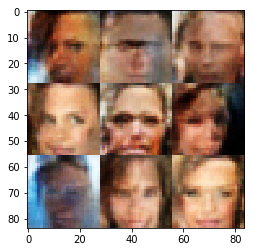

Epoch: 1/1 Iteration: 2210 Discrim. Loss: 1.7928 Generat. Loss: 0.3615
Epoch: 1/1 Iteration: 2220 Discrim. Loss: 1.4961 Generat. Loss: 0.7413
Epoch: 1/1 Iteration: 2230 Discrim. Loss: 1.8948 Generat. Loss: 0.2977
Epoch: 1/1 Iteration: 2240 Discrim. Loss: 1.7947 Generat. Loss: 0.3640
Epoch: 1/1 Iteration: 2250 Discrim. Loss: 1.4669 Generat. Loss: 0.7720
Epoch: 1/1 Iteration: 2260 Discrim. Loss: 1.8059 Generat. Loss: 0.3051
Epoch: 1/1 Iteration: 2270 Discrim. Loss: 1.5411 Generat. Loss: 0.6218
Epoch: 1/1 Iteration: 2280 Discrim. Loss: 1.4453 Generat. Loss: 0.5695
Epoch: 1/1 Iteration: 2290 Discrim. Loss: 1.8696 Generat. Loss: 0.2968
Epoch: 1/1 Iteration: 2300 Discrim. Loss: 1.3218 Generat. Loss: 0.6892


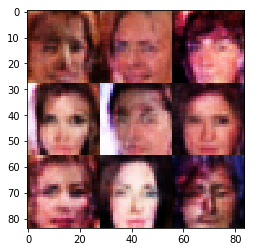

Epoch: 1/1 Iteration: 2310 Discrim. Loss: 1.5157 Generat. Loss: 0.5352
Epoch: 1/1 Iteration: 2320 Discrim. Loss: 1.6544 Generat. Loss: 0.4744
Epoch: 1/1 Iteration: 2330 Discrim. Loss: 1.5862 Generat. Loss: 0.5723
Epoch: 1/1 Iteration: 2340 Discrim. Loss: 1.5674 Generat. Loss: 0.4754
Epoch: 1/1 Iteration: 2350 Discrim. Loss: 1.4847 Generat. Loss: 0.4448
Epoch: 1/1 Iteration: 2360 Discrim. Loss: 1.8842 Generat. Loss: 0.3011
Epoch: 1/1 Iteration: 2370 Discrim. Loss: 1.9312 Generat. Loss: 0.3068
Epoch: 1/1 Iteration: 2380 Discrim. Loss: 1.6981 Generat. Loss: 0.3988
Epoch: 1/1 Iteration: 2390 Discrim. Loss: 1.8287 Generat. Loss: 0.3899
Epoch: 1/1 Iteration: 2400 Discrim. Loss: 1.5890 Generat. Loss: 1.2998


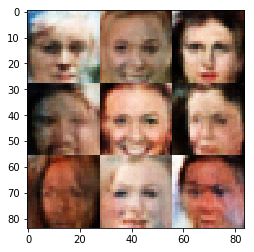

Epoch: 1/1 Iteration: 2410 Discrim. Loss: 1.9379 Generat. Loss: 0.2606
Epoch: 1/1 Iteration: 2420 Discrim. Loss: 1.5505 Generat. Loss: 0.5020
Epoch: 1/1 Iteration: 2430 Discrim. Loss: 1.6528 Generat. Loss: 0.3669
Epoch: 1/1 Iteration: 2440 Discrim. Loss: 1.7917 Generat. Loss: 0.2893
Epoch: 1/1 Iteration: 2450 Discrim. Loss: 1.5165 Generat. Loss: 0.6174
Epoch: 1/1 Iteration: 2460 Discrim. Loss: 1.6534 Generat. Loss: 0.3777
Epoch: 1/1 Iteration: 2470 Discrim. Loss: 1.8726 Generat. Loss: 0.2746
Epoch: 1/1 Iteration: 2480 Discrim. Loss: 1.5643 Generat. Loss: 0.4310
Epoch: 1/1 Iteration: 2490 Discrim. Loss: 1.6755 Generat. Loss: 0.4187
Epoch: 1/1 Iteration: 2500 Discrim. Loss: 1.6064 Generat. Loss: 0.4554


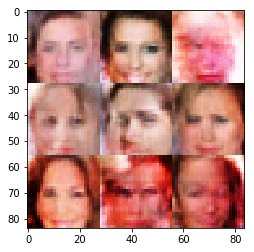

Epoch: 1/1 Iteration: 2510 Discrim. Loss: 1.5367 Generat. Loss: 0.6040
Epoch: 1/1 Iteration: 2520 Discrim. Loss: 1.8206 Generat. Loss: 0.2948
Epoch: 1/1 Iteration: 2530 Discrim. Loss: 1.6627 Generat. Loss: 0.3624
Epoch: 1/1 Iteration: 2540 Discrim. Loss: 1.5899 Generat. Loss: 0.4525
Epoch: 1/1 Iteration: 2550 Discrim. Loss: 1.5003 Generat. Loss: 0.6940
Epoch: 1/1 Iteration: 2560 Discrim. Loss: 1.6014 Generat. Loss: 0.6274
Epoch: 1/1 Iteration: 2570 Discrim. Loss: 1.2182 Generat. Loss: 0.6709
Epoch: 1/1 Iteration: 2580 Discrim. Loss: 1.6134 Generat. Loss: 0.7332
Epoch: 1/1 Iteration: 2590 Discrim. Loss: 1.7592 Generat. Loss: 0.3392
Epoch: 1/1 Iteration: 2600 Discrim. Loss: 1.7416 Generat. Loss: 0.5299


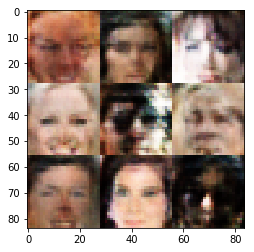

Epoch: 1/1 Iteration: 2610 Discrim. Loss: 1.5526 Generat. Loss: 0.5142
Epoch: 1/1 Iteration: 2620 Discrim. Loss: 1.6931 Generat. Loss: 0.3572
Epoch: 1/1 Iteration: 2630 Discrim. Loss: 1.5967 Generat. Loss: 0.4185
Epoch: 1/1 Iteration: 2640 Discrim. Loss: 1.8182 Generat. Loss: 0.3381
Epoch: 1/1 Iteration: 2650 Discrim. Loss: 1.8204 Generat. Loss: 0.2936
Epoch: 1/1 Iteration: 2660 Discrim. Loss: 1.9365 Generat. Loss: 0.3222
Epoch: 1/1 Iteration: 2670 Discrim. Loss: 1.4289 Generat. Loss: 0.5630
Epoch: 1/1 Iteration: 2680 Discrim. Loss: 1.9235 Generat. Loss: 0.3189
Epoch: 1/1 Iteration: 2690 Discrim. Loss: 1.6331 Generat. Loss: 0.5363
Epoch: 1/1 Iteration: 2700 Discrim. Loss: 1.9227 Generat. Loss: 0.2691


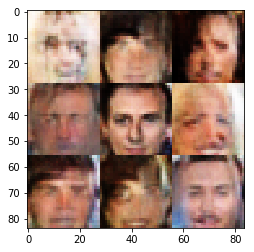

Epoch: 1/1 Iteration: 2710 Discrim. Loss: 1.8450 Generat. Loss: 0.3123
Epoch: 1/1 Iteration: 2720 Discrim. Loss: 1.5228 Generat. Loss: 0.5158
Epoch: 1/1 Iteration: 2730 Discrim. Loss: 1.7172 Generat. Loss: 0.4643
Epoch: 1/1 Iteration: 2740 Discrim. Loss: 1.7116 Generat. Loss: 0.4382
Epoch: 1/1 Iteration: 2750 Discrim. Loss: 1.5815 Generat. Loss: 0.6517
Epoch: 1/1 Iteration: 2760 Discrim. Loss: 1.8682 Generat. Loss: 0.2786
Epoch: 1/1 Iteration: 2770 Discrim. Loss: 1.8352 Generat. Loss: 0.2975
Epoch: 1/1 Iteration: 2780 Discrim. Loss: 2.1165 Generat. Loss: 0.2256
Epoch: 1/1 Iteration: 2790 Discrim. Loss: 1.7009 Generat. Loss: 0.4148
Epoch: 1/1 Iteration: 2800 Discrim. Loss: 1.6804 Generat. Loss: 0.3824


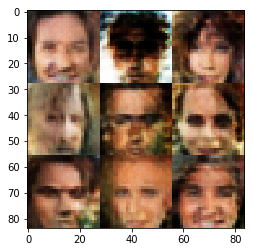

Epoch: 1/1 Iteration: 2810 Discrim. Loss: 1.8260 Generat. Loss: 0.3079
Epoch: 1/1 Iteration: 2820 Discrim. Loss: 1.8765 Generat. Loss: 0.2788
Epoch: 1/1 Iteration: 2830 Discrim. Loss: 1.6290 Generat. Loss: 0.4282
Epoch: 1/1 Iteration: 2840 Discrim. Loss: 1.9915 Generat. Loss: 0.2446
Epoch: 1/1 Iteration: 2850 Discrim. Loss: 2.0151 Generat. Loss: 0.2474
Epoch: 1/1 Iteration: 2860 Discrim. Loss: 1.8468 Generat. Loss: 0.4223
Epoch: 1/1 Iteration: 2870 Discrim. Loss: 1.4424 Generat. Loss: 0.5489
Epoch: 1/1 Iteration: 2880 Discrim. Loss: 1.9289 Generat. Loss: 0.2536
Epoch: 1/1 Iteration: 2890 Discrim. Loss: 1.6275 Generat. Loss: 0.3667
Epoch: 1/1 Iteration: 2900 Discrim. Loss: 1.9678 Generat. Loss: 0.2607


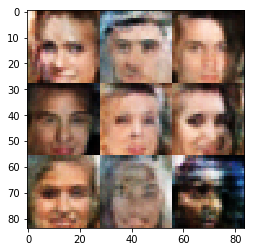

Epoch: 1/1 Iteration: 2910 Discrim. Loss: 1.5263 Generat. Loss: 1.1768
Epoch: 1/1 Iteration: 2920 Discrim. Loss: 1.6342 Generat. Loss: 0.4091
Epoch: 1/1 Iteration: 2930 Discrim. Loss: 1.9305 Generat. Loss: 0.2881
Epoch: 1/1 Iteration: 2940 Discrim. Loss: 2.1219 Generat. Loss: 0.2268
Epoch: 1/1 Iteration: 2950 Discrim. Loss: 1.7364 Generat. Loss: 0.3902
Epoch: 1/1 Iteration: 2960 Discrim. Loss: 1.6991 Generat. Loss: 0.4120
Epoch: 1/1 Iteration: 2970 Discrim. Loss: 1.9686 Generat. Loss: 0.2457
Epoch: 1/1 Iteration: 2980 Discrim. Loss: 1.5604 Generat. Loss: 0.4378
Epoch: 1/1 Iteration: 2990 Discrim. Loss: 2.0041 Generat. Loss: 0.2397
Epoch: 1/1 Iteration: 3000 Discrim. Loss: 1.6251 Generat. Loss: 0.3862


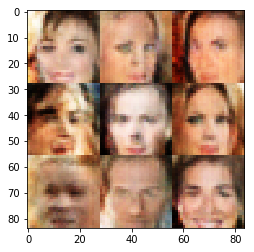

Epoch: 1/1 Iteration: 3010 Discrim. Loss: 1.9109 Generat. Loss: 0.2800
Epoch: 1/1 Iteration: 3020 Discrim. Loss: 1.9397 Generat. Loss: 0.2647
Epoch: 1/1 Iteration: 3030 Discrim. Loss: 1.4683 Generat. Loss: 0.5942
Epoch: 1/1 Iteration: 3040 Discrim. Loss: 1.4753 Generat. Loss: 0.6398
Epoch: 1/1 Iteration: 3050 Discrim. Loss: 1.4949 Generat. Loss: 0.5883
Epoch: 1/1 Iteration: 3060 Discrim. Loss: 1.8369 Generat. Loss: 0.3084
Epoch: 1/1 Iteration: 3070 Discrim. Loss: 1.6933 Generat. Loss: 0.4337
Epoch: 1/1 Iteration: 3080 Discrim. Loss: 1.4983 Generat. Loss: 0.4465
Epoch: 1/1 Iteration: 3090 Discrim. Loss: 2.4067 Generat. Loss: 0.1633
Epoch: 1/1 Iteration: 3100 Discrim. Loss: 1.7912 Generat. Loss: 0.3797


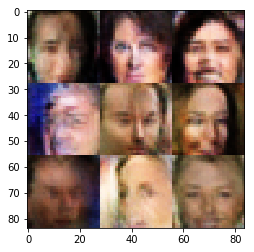

Epoch: 1/1 Iteration: 3110 Discrim. Loss: 1.8262 Generat. Loss: 0.2930
Epoch: 1/1 Iteration: 3120 Discrim. Loss: 1.8789 Generat. Loss: 0.3184
Epoch: 1/1 Iteration: 3130 Discrim. Loss: 1.5298 Generat. Loss: 0.8724
Epoch: 1/1 Iteration: 3140 Discrim. Loss: 1.6355 Generat. Loss: 0.3748
Epoch: 1/1 Iteration: 3150 Discrim. Loss: 2.0291 Generat. Loss: 0.2324
Epoch: 1/1 Iteration: 3160 Discrim. Loss: 1.8108 Generat. Loss: 0.3051
Epoch: 1/1 Iteration: 3170 Discrim. Loss: 1.8854 Generat. Loss: 0.3356
Epoch: 1/1 Iteration: 3180 Discrim. Loss: 1.7809 Generat. Loss: 0.3097
Epoch: 1/1 Iteration: 3190 Discrim. Loss: 1.9165 Generat. Loss: 0.3346
Epoch: 1/1 Iteration: 3200 Discrim. Loss: 1.8597 Generat. Loss: 0.3063


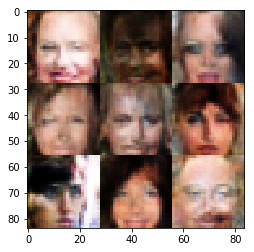

Epoch: 1/1 Iteration: 3210 Discrim. Loss: 1.9923 Generat. Loss: 0.2670
Epoch: 1/1 Iteration: 3220 Discrim. Loss: 1.7709 Generat. Loss: 0.4083
Epoch: 1/1 Iteration: 3230 Discrim. Loss: 1.6325 Generat. Loss: 0.5717
Epoch: 1/1 Iteration: 3240 Discrim. Loss: 2.0890 Generat. Loss: 0.3061
Epoch: 1/1 Iteration: 3250 Discrim. Loss: 1.8381 Generat. Loss: 0.3095
Epoch: 1/1 Iteration: 3260 Discrim. Loss: 1.8202 Generat. Loss: 0.3570
Epoch: 1/1 Iteration: 3270 Discrim. Loss: 2.0960 Generat. Loss: 0.2117
Epoch: 1/1 Iteration: 3280 Discrim. Loss: 2.0950 Generat. Loss: 0.2184
Epoch: 1/1 Iteration: 3290 Discrim. Loss: 1.5366 Generat. Loss: 0.6555
Epoch: 1/1 Iteration: 3300 Discrim. Loss: 1.5831 Generat. Loss: 0.6594


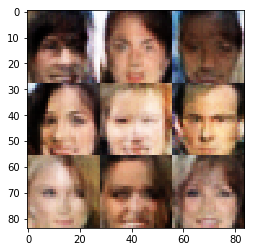

Epoch: 1/1 Iteration: 3310 Discrim. Loss: 1.7293 Generat. Loss: 0.6837
Epoch: 1/1 Iteration: 3320 Discrim. Loss: 1.8710 Generat. Loss: 0.2790
Epoch: 1/1 Iteration: 3330 Discrim. Loss: 1.6634 Generat. Loss: 0.3930
Epoch: 1/1 Iteration: 3340 Discrim. Loss: 1.7257 Generat. Loss: 0.3514
Epoch: 1/1 Iteration: 3350 Discrim. Loss: 1.9249 Generat. Loss: 0.2759
Epoch: 1/1 Iteration: 3360 Discrim. Loss: 1.6552 Generat. Loss: 0.4195
Epoch: 1/1 Iteration: 3370 Discrim. Loss: 1.9436 Generat. Loss: 0.2721
Epoch: 1/1 Iteration: 3380 Discrim. Loss: 1.6911 Generat. Loss: 0.4350
Epoch: 1/1 Iteration: 3390 Discrim. Loss: 2.1831 Generat. Loss: 0.2103
Epoch: 1/1 Iteration: 3400 Discrim. Loss: 1.4589 Generat. Loss: 0.9469


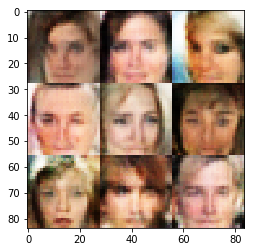

Epoch: 1/1 Iteration: 3410 Discrim. Loss: 1.6043 Generat. Loss: 0.3973
Epoch: 1/1 Iteration: 3420 Discrim. Loss: 1.5534 Generat. Loss: 0.5342
Epoch: 1/1 Iteration: 3430 Discrim. Loss: 1.9408 Generat. Loss: 0.2686
Epoch: 1/1 Iteration: 3440 Discrim. Loss: 1.7175 Generat. Loss: 0.8463
Epoch: 1/1 Iteration: 3450 Discrim. Loss: 1.8525 Generat. Loss: 0.2945
Epoch: 1/1 Iteration: 3460 Discrim. Loss: 1.6197 Generat. Loss: 0.4301
Epoch: 1/1 Iteration: 3470 Discrim. Loss: 2.1183 Generat. Loss: 0.2194
Epoch: 1/1 Iteration: 3480 Discrim. Loss: 1.9595 Generat. Loss: 0.2776
Epoch: 1/1 Iteration: 3490 Discrim. Loss: 1.7182 Generat. Loss: 0.4534
Epoch: 1/1 Iteration: 3500 Discrim. Loss: 1.8690 Generat. Loss: 0.3201


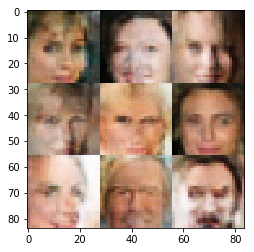

Epoch: 1/1 Iteration: 3510 Discrim. Loss: 1.7882 Generat. Loss: 0.2831
Epoch: 1/1 Iteration: 3520 Discrim. Loss: 1.8225 Generat. Loss: 0.3335
Epoch: 1/1 Iteration: 3530 Discrim. Loss: 1.8977 Generat. Loss: 0.2703
Epoch: 1/1 Iteration: 3540 Discrim. Loss: 1.7805 Generat. Loss: 0.4470
Epoch: 1/1 Iteration: 3550 Discrim. Loss: 1.5746 Generat. Loss: 0.4762
Epoch: 1/1 Iteration: 3560 Discrim. Loss: 1.3993 Generat. Loss: 0.9983
Epoch: 1/1 Iteration: 3570 Discrim. Loss: 2.0838 Generat. Loss: 0.2249
Epoch: 1/1 Iteration: 3580 Discrim. Loss: 1.8990 Generat. Loss: 0.3440
Epoch: 1/1 Iteration: 3590 Discrim. Loss: 1.9467 Generat. Loss: 0.2455
Epoch: 1/1 Iteration: 3600 Discrim. Loss: 1.5276 Generat. Loss: 0.4942


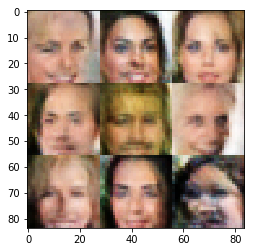

Epoch: 1/1 Iteration: 3610 Discrim. Loss: 2.0707 Generat. Loss: 0.2172
Epoch: 1/1 Iteration: 3620 Discrim. Loss: 2.0040 Generat. Loss: 0.2450
Epoch: 1/1 Iteration: 3630 Discrim. Loss: 1.6692 Generat. Loss: 0.3674
Epoch: 1/1 Iteration: 3640 Discrim. Loss: 1.4708 Generat. Loss: 0.4635
Epoch: 1/1 Iteration: 3650 Discrim. Loss: 1.8774 Generat. Loss: 0.2706
Epoch: 1/1 Iteration: 3660 Discrim. Loss: 1.6704 Generat. Loss: 0.4643
Epoch: 1/1 Iteration: 3670 Discrim. Loss: 1.6647 Generat. Loss: 0.4426
Epoch: 1/1 Iteration: 3680 Discrim. Loss: 1.9981 Generat. Loss: 0.2748
Epoch: 1/1 Iteration: 3690 Discrim. Loss: 1.8249 Generat. Loss: 0.3196
Epoch: 1/1 Iteration: 3700 Discrim. Loss: 1.5434 Generat. Loss: 0.4725


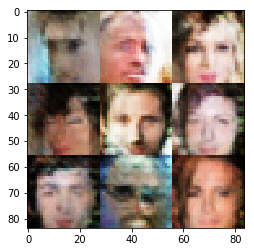

Epoch: 1/1 Iteration: 3710 Discrim. Loss: 1.9546 Generat. Loss: 0.2812
Epoch: 1/1 Iteration: 3720 Discrim. Loss: 1.8376 Generat. Loss: 0.2974
Epoch: 1/1 Iteration: 3730 Discrim. Loss: 1.8721 Generat. Loss: 0.2876
Epoch: 1/1 Iteration: 3740 Discrim. Loss: 1.8805 Generat. Loss: 0.2778
Epoch: 1/1 Iteration: 3750 Discrim. Loss: 1.6600 Generat. Loss: 0.4584
Epoch: 1/1 Iteration: 3760 Discrim. Loss: 2.0759 Generat. Loss: 0.2295
Epoch: 1/1 Iteration: 3770 Discrim. Loss: 2.0727 Generat. Loss: 0.2443
Epoch: 1/1 Iteration: 3780 Discrim. Loss: 1.5158 Generat. Loss: 0.5379
Epoch: 1/1 Iteration: 3790 Discrim. Loss: 1.7314 Generat. Loss: 0.3519
Epoch: 1/1 Iteration: 3800 Discrim. Loss: 1.7700 Generat. Loss: 0.3618


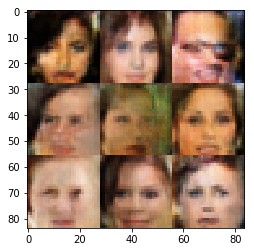

Epoch: 1/1 Iteration: 3810 Discrim. Loss: 1.7146 Generat. Loss: 0.3460
Epoch: 1/1 Iteration: 3820 Discrim. Loss: 1.6106 Generat. Loss: 0.6126
Epoch: 1/1 Iteration: 3830 Discrim. Loss: 1.5661 Generat. Loss: 0.5220
Epoch: 1/1 Iteration: 3840 Discrim. Loss: 1.6756 Generat. Loss: 0.5269
Epoch: 1/1 Iteration: 3850 Discrim. Loss: 1.6752 Generat. Loss: 0.4016
Epoch: 1/1 Iteration: 3860 Discrim. Loss: 1.6515 Generat. Loss: 0.4423
Epoch: 1/1 Iteration: 3870 Discrim. Loss: 1.7660 Generat. Loss: 0.3707
Epoch: 1/1 Iteration: 3880 Discrim. Loss: 1.5910 Generat. Loss: 0.5476
Epoch: 1/1 Iteration: 3890 Discrim. Loss: 1.6569 Generat. Loss: 0.3379
Epoch: 1/1 Iteration: 3900 Discrim. Loss: 1.5352 Generat. Loss: 1.2656


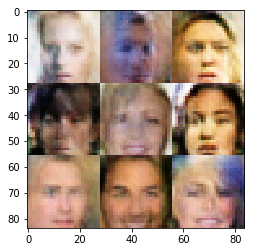

Epoch: 1/1 Iteration: 3910 Discrim. Loss: 1.6469 Generat. Loss: 0.5051
Epoch: 1/1 Iteration: 3920 Discrim. Loss: 1.9905 Generat. Loss: 0.2882
Epoch: 1/1 Iteration: 3930 Discrim. Loss: 1.8826 Generat. Loss: 0.2968
Epoch: 1/1 Iteration: 3940 Discrim. Loss: 1.7355 Generat. Loss: 0.3262
Epoch: 1/1 Iteration: 3950 Discrim. Loss: 1.6118 Generat. Loss: 0.4101
Epoch: 1/1 Iteration: 3960 Discrim. Loss: 1.5636 Generat. Loss: 0.4236
Epoch: 1/1 Iteration: 3970 Discrim. Loss: 1.9009 Generat. Loss: 0.2973
Epoch: 1/1 Iteration: 3980 Discrim. Loss: 1.7791 Generat. Loss: 0.4159
Epoch: 1/1 Iteration: 3990 Discrim. Loss: 1.5280 Generat. Loss: 0.4916
Epoch: 1/1 Iteration: 4000 Discrim. Loss: 1.5805 Generat. Loss: 0.4126


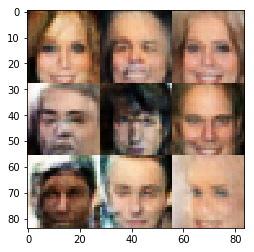

Epoch: 1/1 Iteration: 4010 Discrim. Loss: 1.7535 Generat. Loss: 0.4318
Epoch: 1/1 Iteration: 4020 Discrim. Loss: 1.8169 Generat. Loss: 0.2861
Epoch: 1/1 Iteration: 4030 Discrim. Loss: 2.1298 Generat. Loss: 0.2088
Epoch: 1/1 Iteration: 4040 Discrim. Loss: 2.2611 Generat. Loss: 0.1775
Epoch: 1/1 Iteration: 4050 Discrim. Loss: 1.7471 Generat. Loss: 0.3659
Epoch: 1/1 Iteration: 4060 Discrim. Loss: 1.9891 Generat. Loss: 0.2338
Epoch: 1/1 Iteration: 4070 Discrim. Loss: 1.7047 Generat. Loss: 0.3359
Epoch: 1/1 Iteration: 4080 Discrim. Loss: 2.0052 Generat. Loss: 0.2344
Epoch: 1/1 Iteration: 4090 Discrim. Loss: 1.3825 Generat. Loss: 0.6201
Epoch: 1/1 Iteration: 4100 Discrim. Loss: 1.6667 Generat. Loss: 0.5071


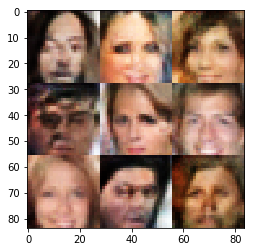

Epoch: 1/1 Iteration: 4110 Discrim. Loss: 1.7378 Generat. Loss: 0.3761
Epoch: 1/1 Iteration: 4120 Discrim. Loss: 1.8268 Generat. Loss: 0.3227
Epoch: 1/1 Iteration: 4130 Discrim. Loss: 1.8155 Generat. Loss: 0.3271
Epoch: 1/1 Iteration: 4140 Discrim. Loss: 1.5038 Generat. Loss: 0.4926
Epoch: 1/1 Iteration: 4150 Discrim. Loss: 1.8133 Generat. Loss: 0.4810
Epoch: 1/1 Iteration: 4160 Discrim. Loss: 2.0445 Generat. Loss: 0.2403
Epoch: 1/1 Iteration: 4170 Discrim. Loss: 1.5824 Generat. Loss: 0.4917
Epoch: 1/1 Iteration: 4180 Discrim. Loss: 1.5635 Generat. Loss: 0.4275
Epoch: 1/1 Iteration: 4190 Discrim. Loss: 1.4787 Generat. Loss: 0.6851
Epoch: 1/1 Iteration: 4200 Discrim. Loss: 1.5589 Generat. Loss: 0.4945


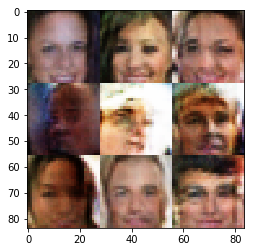

Epoch: 1/1 Iteration: 4210 Discrim. Loss: 1.8621 Generat. Loss: 0.2914
Epoch: 1/1 Iteration: 4220 Discrim. Loss: 1.8637 Generat. Loss: 0.3268
Epoch: 1/1 Iteration: 4230 Discrim. Loss: 1.8451 Generat. Loss: 0.3707
Epoch: 1/1 Iteration: 4240 Discrim. Loss: 1.7735 Generat. Loss: 0.3694
Epoch: 1/1 Iteration: 4250 Discrim. Loss: 1.5304 Generat. Loss: 0.5431
Epoch: 1/1 Iteration: 4260 Discrim. Loss: 1.5872 Generat. Loss: 0.4170
Epoch: 1/1 Iteration: 4270 Discrim. Loss: 1.8216 Generat. Loss: 0.3876
Epoch: 1/1 Iteration: 4280 Discrim. Loss: 1.8195 Generat. Loss: 0.2990
Epoch: 1/1 Iteration: 4290 Discrim. Loss: 1.8231 Generat. Loss: 0.4026
Epoch: 1/1 Iteration: 4300 Discrim. Loss: 1.7713 Generat. Loss: 0.4429


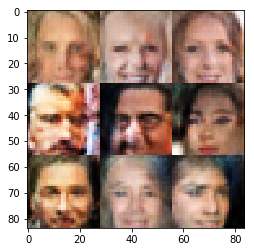

Epoch: 1/1 Iteration: 4310 Discrim. Loss: 2.0730 Generat. Loss: 0.2607
Epoch: 1/1 Iteration: 4320 Discrim. Loss: 2.0740 Generat. Loss: 0.2855
Epoch: 1/1 Iteration: 4330 Discrim. Loss: 1.6934 Generat. Loss: 0.3549
Epoch: 1/1 Iteration: 4340 Discrim. Loss: 1.7503 Generat. Loss: 0.3878
Epoch: 1/1 Iteration: 4350 Discrim. Loss: 1.7448 Generat. Loss: 0.5087
Epoch: 1/1 Iteration: 4360 Discrim. Loss: 1.8607 Generat. Loss: 0.4146
Epoch: 1/1 Iteration: 4370 Discrim. Loss: 1.9235 Generat. Loss: 0.4288
Epoch: 1/1 Iteration: 4380 Discrim. Loss: 1.7224 Generat. Loss: 0.4766
Epoch: 1/1 Iteration: 4390 Discrim. Loss: 1.5923 Generat. Loss: 0.4345
Epoch: 1/1 Iteration: 4400 Discrim. Loss: 1.9634 Generat. Loss: 0.2738


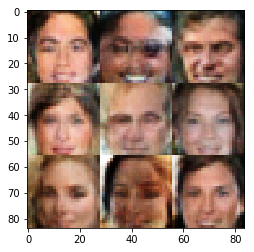

Epoch: 1/1 Iteration: 4410 Discrim. Loss: 2.2264 Generat. Loss: 0.1941
Epoch: 1/1 Iteration: 4420 Discrim. Loss: 1.8901 Generat. Loss: 0.2843
Epoch: 1/1 Iteration: 4430 Discrim. Loss: 1.8659 Generat. Loss: 0.3535
Epoch: 1/1 Iteration: 4440 Discrim. Loss: 1.6324 Generat. Loss: 0.4140
Epoch: 1/1 Iteration: 4450 Discrim. Loss: 2.0315 Generat. Loss: 0.2302
Epoch: 1/1 Iteration: 4460 Discrim. Loss: 1.8632 Generat. Loss: 0.3866
Epoch: 1/1 Iteration: 4470 Discrim. Loss: 1.9338 Generat. Loss: 0.2412
Epoch: 1/1 Iteration: 4480 Discrim. Loss: 1.8738 Generat. Loss: 0.2864
Epoch: 1/1 Iteration: 4490 Discrim. Loss: 2.0738 Generat. Loss: 0.2237
Epoch: 1/1 Iteration: 4500 Discrim. Loss: 1.7823 Generat. Loss: 0.3089


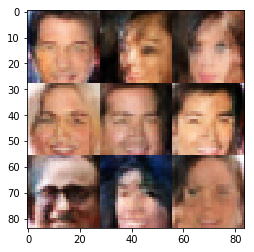

Epoch: 1/1 Iteration: 4510 Discrim. Loss: 1.7165 Generat. Loss: 0.3410
Epoch: 1/1 Iteration: 4520 Discrim. Loss: 1.9613 Generat. Loss: 0.2557
Epoch: 1/1 Iteration: 4530 Discrim. Loss: 1.5425 Generat. Loss: 0.4642
Epoch: 1/1 Iteration: 4540 Discrim. Loss: 1.8673 Generat. Loss: 0.2867
Epoch: 1/1 Iteration: 4550 Discrim. Loss: 1.9248 Generat. Loss: 0.2549
Epoch: 1/1 Iteration: 4560 Discrim. Loss: 2.0026 Generat. Loss: 0.2688
Epoch: 1/1 Iteration: 4570 Discrim. Loss: 1.8477 Generat. Loss: 0.2703
Epoch: 1/1 Iteration: 4580 Discrim. Loss: 1.6964 Generat. Loss: 0.4160
Epoch: 1/1 Iteration: 4590 Discrim. Loss: 1.6065 Generat. Loss: 0.4777
Epoch: 1/1 Iteration: 4600 Discrim. Loss: 2.1167 Generat. Loss: 0.2057


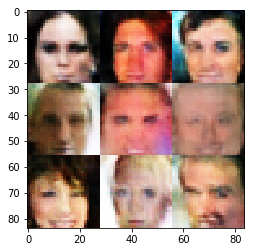

Epoch: 1/1 Iteration: 4610 Discrim. Loss: 1.7878 Generat. Loss: 0.3775
Epoch: 1/1 Iteration: 4620 Discrim. Loss: 2.0714 Generat. Loss: 0.2790
Epoch: 1/1 Iteration: 4630 Discrim. Loss: 1.9112 Generat. Loss: 0.3159
Epoch: 1/1 Iteration: 4640 Discrim. Loss: 1.7570 Generat. Loss: 0.3582
Epoch: 1/1 Iteration: 4650 Discrim. Loss: 1.9012 Generat. Loss: 0.2697
Epoch: 1/1 Iteration: 4660 Discrim. Loss: 1.9788 Generat. Loss: 0.2635
Epoch: 1/1 Iteration: 4670 Discrim. Loss: 1.8039 Generat. Loss: 0.2831
Epoch: 1/1 Iteration: 4680 Discrim. Loss: 2.2062 Generat. Loss: 0.1833
Epoch: 1/1 Iteration: 4690 Discrim. Loss: 1.8519 Generat. Loss: 0.2912
Epoch: 1/1 Iteration: 4700 Discrim. Loss: 2.1771 Generat. Loss: 0.1926


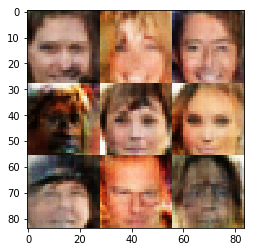

Epoch: 1/1 Iteration: 4710 Discrim. Loss: 1.9833 Generat. Loss: 0.2343
Epoch: 1/1 Iteration: 4720 Discrim. Loss: 2.2883 Generat. Loss: 0.2019
Epoch: 1/1 Iteration: 4730 Discrim. Loss: 1.8305 Generat. Loss: 0.2798
Epoch: 1/1 Iteration: 4740 Discrim. Loss: 2.0230 Generat. Loss: 0.3197
Epoch: 1/1 Iteration: 4750 Discrim. Loss: 1.8215 Generat. Loss: 0.3079
Epoch: 1/1 Iteration: 4760 Discrim. Loss: 2.4113 Generat. Loss: 0.1548
Epoch: 1/1 Iteration: 4770 Discrim. Loss: 2.1347 Generat. Loss: 0.2088
Epoch: 1/1 Iteration: 4780 Discrim. Loss: 1.5952 Generat. Loss: 0.5276
Epoch: 1/1 Iteration: 4790 Discrim. Loss: 1.7239 Generat. Loss: 0.3533
Epoch: 1/1 Iteration: 4800 Discrim. Loss: 2.1036 Generat. Loss: 0.2218


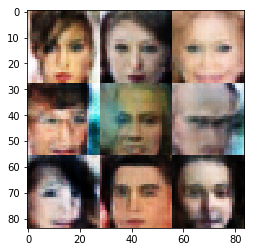

Epoch: 1/1 Iteration: 4810 Discrim. Loss: 1.8067 Generat. Loss: 0.3281
Epoch: 1/1 Iteration: 4820 Discrim. Loss: 2.0034 Generat. Loss: 0.2471
Epoch: 1/1 Iteration: 4830 Discrim. Loss: 2.0714 Generat. Loss: 0.2203
Epoch: 1/1 Iteration: 4840 Discrim. Loss: 1.7673 Generat. Loss: 0.2953
Epoch: 1/1 Iteration: 4850 Discrim. Loss: 2.4445 Generat. Loss: 0.1462
Epoch: 1/1 Iteration: 4860 Discrim. Loss: 1.8222 Generat. Loss: 0.2932
Epoch: 1/1 Iteration: 4870 Discrim. Loss: 1.6972 Generat. Loss: 0.3528
Epoch: 1/1 Iteration: 4880 Discrim. Loss: 2.0111 Generat. Loss: 0.2631
Epoch: 1/1 Iteration: 4890 Discrim. Loss: 2.1591 Generat. Loss: 0.2273
Epoch: 1/1 Iteration: 4900 Discrim. Loss: 2.2917 Generat. Loss: 0.1699


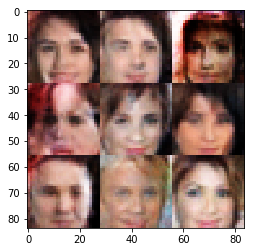

Epoch: 1/1 Iteration: 4910 Discrim. Loss: 2.0459 Generat. Loss: 0.2572
Epoch: 1/1 Iteration: 4920 Discrim. Loss: 2.1829 Generat. Loss: 0.1899
Epoch: 1/1 Iteration: 4930 Discrim. Loss: 1.8273 Generat. Loss: 0.3108
Epoch: 1/1 Iteration: 4940 Discrim. Loss: 1.5928 Generat. Loss: 0.5793
Epoch: 1/1 Iteration: 4950 Discrim. Loss: 1.9432 Generat. Loss: 0.2409
Epoch: 1/1 Iteration: 4960 Discrim. Loss: 1.5512 Generat. Loss: 0.4578
Epoch: 1/1 Iteration: 4970 Discrim. Loss: 1.6156 Generat. Loss: 0.3858
Epoch: 1/1 Iteration: 4980 Discrim. Loss: 2.1480 Generat. Loss: 0.2327
Epoch: 1/1 Iteration: 4990 Discrim. Loss: 1.9966 Generat. Loss: 0.2421
Epoch: 1/1 Iteration: 5000 Discrim. Loss: 1.7805 Generat. Loss: 0.3478


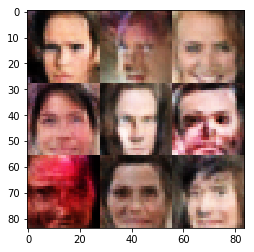

Epoch: 1/1 Iteration: 5010 Discrim. Loss: 1.9492 Generat. Loss: 0.2596
Epoch: 1/1 Iteration: 5020 Discrim. Loss: 1.8467 Generat. Loss: 0.2794
Epoch: 1/1 Iteration: 5030 Discrim. Loss: 1.7874 Generat. Loss: 0.3238
Epoch: 1/1 Iteration: 5040 Discrim. Loss: 1.4515 Generat. Loss: 0.4447
Epoch: 1/1 Iteration: 5050 Discrim. Loss: 1.4940 Generat. Loss: 0.6144
Epoch: 1/1 Iteration: 5060 Discrim. Loss: 1.8175 Generat. Loss: 0.3004
Epoch: 1/1 Iteration: 5070 Discrim. Loss: 1.9053 Generat. Loss: 0.2611
Epoch: 1/1 Iteration: 5080 Discrim. Loss: 1.9734 Generat. Loss: 0.2490
Epoch: 1/1 Iteration: 5090 Discrim. Loss: 1.8210 Generat. Loss: 0.3118
Epoch: 1/1 Iteration: 5100 Discrim. Loss: 2.0907 Generat. Loss: 0.2142


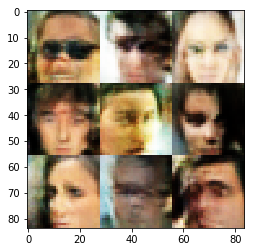

Epoch: 1/1 Iteration: 5110 Discrim. Loss: 1.5165 Generat. Loss: 0.5934
Epoch: 1/1 Iteration: 5120 Discrim. Loss: 1.5797 Generat. Loss: 0.4611
Epoch: 1/1 Iteration: 5130 Discrim. Loss: 2.0144 Generat. Loss: 0.2400
Epoch: 1/1 Iteration: 5140 Discrim. Loss: 1.8413 Generat. Loss: 0.4859
Epoch: 1/1 Iteration: 5150 Discrim. Loss: 1.6696 Generat. Loss: 0.3820
Epoch: 1/1 Iteration: 5160 Discrim. Loss: 1.7125 Generat. Loss: 0.5042
Epoch: 1/1 Iteration: 5170 Discrim. Loss: 1.6482 Generat. Loss: 0.3693
Epoch: 1/1 Iteration: 5180 Discrim. Loss: 2.2929 Generat. Loss: 0.2550
Epoch: 1/1 Iteration: 5190 Discrim. Loss: 1.9105 Generat. Loss: 0.3508
Epoch: 1/1 Iteration: 5200 Discrim. Loss: 1.6965 Generat. Loss: 0.3825


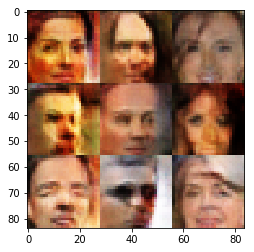

Epoch: 1/1 Iteration: 5210 Discrim. Loss: 1.7633 Generat. Loss: 0.3162
Epoch: 1/1 Iteration: 5220 Discrim. Loss: 2.1417 Generat. Loss: 0.1954
Epoch: 1/1 Iteration: 5230 Discrim. Loss: 2.0358 Generat. Loss: 0.2329
Epoch: 1/1 Iteration: 5240 Discrim. Loss: 1.6962 Generat. Loss: 0.3590
Epoch: 1/1 Iteration: 5250 Discrim. Loss: 1.7520 Generat. Loss: 0.4858
Epoch: 1/1 Iteration: 5260 Discrim. Loss: 1.8196 Generat. Loss: 0.3257
Epoch: 1/1 Iteration: 5270 Discrim. Loss: 2.1180 Generat. Loss: 0.2167
Epoch: 1/1 Iteration: 5280 Discrim. Loss: 1.7516 Generat. Loss: 0.3655
Epoch: 1/1 Iteration: 5290 Discrim. Loss: 2.2425 Generat. Loss: 0.1858
Epoch: 1/1 Iteration: 5300 Discrim. Loss: 2.0998 Generat. Loss: 0.2150


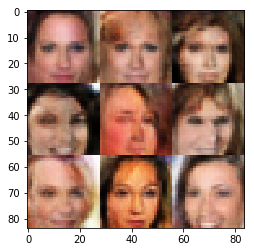

Epoch: 1/1 Iteration: 5310 Discrim. Loss: 1.7594 Generat. Loss: 0.4676
Epoch: 1/1 Iteration: 5320 Discrim. Loss: 1.5560 Generat. Loss: 0.5698
Epoch: 1/1 Iteration: 5330 Discrim. Loss: 1.7521 Generat. Loss: 0.3277
Epoch: 1/1 Iteration: 5340 Discrim. Loss: 2.3619 Generat. Loss: 0.1624
Epoch: 1/1 Iteration: 5350 Discrim. Loss: 2.1280 Generat. Loss: 0.2083
Epoch: 1/1 Iteration: 5360 Discrim. Loss: 1.6831 Generat. Loss: 0.4175
Epoch: 1/1 Iteration: 5370 Discrim. Loss: 1.6036 Generat. Loss: 0.4178
Epoch: 1/1 Iteration: 5380 Discrim. Loss: 2.0082 Generat. Loss: 0.2341
Epoch: 1/1 Iteration: 5390 Discrim. Loss: 1.8810 Generat. Loss: 1.2219
Epoch: 1/1 Iteration: 5400 Discrim. Loss: 2.8046 Generat. Loss: 0.1102


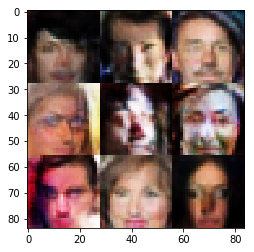

Epoch: 1/1 Iteration: 5410 Discrim. Loss: 1.9062 Generat. Loss: 0.2800
Epoch: 1/1 Iteration: 5420 Discrim. Loss: 1.8168 Generat. Loss: 0.3645
Epoch: 1/1 Iteration: 5430 Discrim. Loss: 1.9559 Generat. Loss: 0.2477
Epoch: 1/1 Iteration: 5440 Discrim. Loss: 1.5795 Generat. Loss: 0.3692
Epoch: 1/1 Iteration: 5450 Discrim. Loss: 1.8670 Generat. Loss: 0.2906
Epoch: 1/1 Iteration: 5460 Discrim. Loss: 2.0191 Generat. Loss: 0.2468
Epoch: 1/1 Iteration: 5470 Discrim. Loss: 1.9299 Generat. Loss: 0.2641
Epoch: 1/1 Iteration: 5480 Discrim. Loss: 2.1061 Generat. Loss: 0.2113
Epoch: 1/1 Iteration: 5490 Discrim. Loss: 1.6053 Generat. Loss: 0.3994
Epoch: 1/1 Iteration: 5500 Discrim. Loss: 1.6463 Generat. Loss: 0.4033


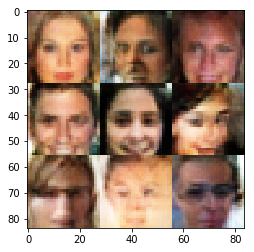

Epoch: 1/1 Iteration: 5510 Discrim. Loss: 1.8358 Generat. Loss: 0.3444
Epoch: 1/1 Iteration: 5520 Discrim. Loss: 1.8967 Generat. Loss: 0.3149
Epoch: 1/1 Iteration: 5530 Discrim. Loss: 1.9832 Generat. Loss: 0.2393
Epoch: 1/1 Iteration: 5540 Discrim. Loss: 2.1595 Generat. Loss: 0.2162
Epoch: 1/1 Iteration: 5550 Discrim. Loss: 1.6951 Generat. Loss: 0.4081
Epoch: 1/1 Iteration: 5560 Discrim. Loss: 2.2417 Generat. Loss: 0.1876
Epoch: 1/1 Iteration: 5570 Discrim. Loss: 1.8818 Generat. Loss: 0.5681
Epoch: 1/1 Iteration: 5580 Discrim. Loss: 2.0552 Generat. Loss: 0.2434
Epoch: 1/1 Iteration: 5590 Discrim. Loss: 1.7777 Generat. Loss: 0.3410
Epoch: 1/1 Iteration: 5600 Discrim. Loss: 1.7873 Generat. Loss: 0.3184


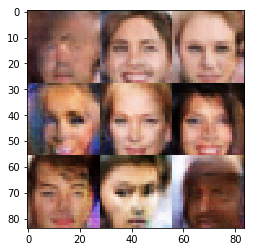

Epoch: 1/1 Iteration: 5610 Discrim. Loss: 2.0063 Generat. Loss: 0.2823
Epoch: 1/1 Iteration: 5620 Discrim. Loss: 1.9799 Generat. Loss: 0.2673
Epoch: 1/1 Iteration: 5630 Discrim. Loss: 1.8284 Generat. Loss: 0.3023
Epoch: 1/1 Iteration: 5640 Discrim. Loss: 1.7472 Generat. Loss: 0.3794
Epoch: 1/1 Iteration: 5650 Discrim. Loss: 1.5208 Generat. Loss: 0.7695
Epoch: 1/1 Iteration: 5660 Discrim. Loss: 2.0117 Generat. Loss: 0.2423
Epoch: 1/1 Iteration: 5670 Discrim. Loss: 1.5444 Generat. Loss: 0.5713
Epoch: 1/1 Iteration: 5680 Discrim. Loss: 1.5959 Generat. Loss: 0.4677
Epoch: 1/1 Iteration: 5690 Discrim. Loss: 2.0977 Generat. Loss: 0.2444
Epoch: 1/1 Iteration: 5700 Discrim. Loss: 2.2096 Generat. Loss: 0.1821


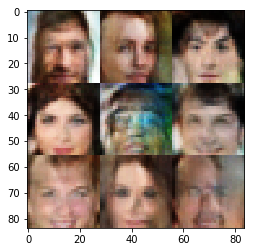

Epoch: 1/1 Iteration: 5710 Discrim. Loss: 2.0486 Generat. Loss: 0.3841
Epoch: 1/1 Iteration: 5720 Discrim. Loss: 1.7590 Generat. Loss: 0.5704
Epoch: 1/1 Iteration: 5730 Discrim. Loss: 1.7326 Generat. Loss: 0.4385
Epoch: 1/1 Iteration: 5740 Discrim. Loss: 1.3653 Generat. Loss: 0.6307
Epoch: 1/1 Iteration: 5750 Discrim. Loss: 1.8984 Generat. Loss: 0.2740
Epoch: 1/1 Iteration: 5760 Discrim. Loss: 1.2242 Generat. Loss: 0.7231
Epoch: 1/1 Iteration: 5770 Discrim. Loss: 1.6673 Generat. Loss: 0.5110
Epoch: 1/1 Iteration: 5780 Discrim. Loss: 1.3029 Generat. Loss: 0.7327
Epoch: 1/1 Iteration: 5790 Discrim. Loss: 2.0629 Generat. Loss: 0.2209
Epoch: 1/1 Iteration: 5800 Discrim. Loss: 1.9538 Generat. Loss: 0.2679


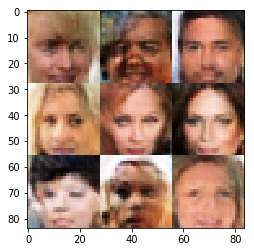

Epoch: 1/1 Iteration: 5810 Discrim. Loss: 1.5538 Generat. Loss: 0.4618
Epoch: 1/1 Iteration: 5820 Discrim. Loss: 1.7418 Generat. Loss: 0.7952
Epoch: 1/1 Iteration: 5830 Discrim. Loss: 1.7257 Generat. Loss: 0.3505
Epoch: 1/1 Iteration: 5840 Discrim. Loss: 1.8243 Generat. Loss: 0.3527
Epoch: 1/1 Iteration: 5850 Discrim. Loss: 2.2998 Generat. Loss: 0.1665
Epoch: 1/1 Iteration: 5860 Discrim. Loss: 2.0284 Generat. Loss: 0.2718
Epoch: 1/1 Iteration: 5870 Discrim. Loss: 2.0767 Generat. Loss: 0.2319
Epoch: 1/1 Iteration: 5880 Discrim. Loss: 1.8519 Generat. Loss: 0.2954
Epoch: 1/1 Iteration: 5890 Discrim. Loss: 2.0205 Generat. Loss: 0.2339
Epoch: 1/1 Iteration: 5900 Discrim. Loss: 2.0132 Generat. Loss: 0.2346


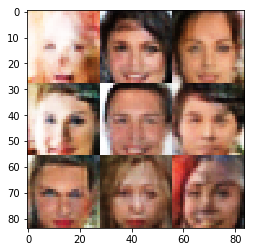

Epoch: 1/1 Iteration: 5910 Discrim. Loss: 2.1501 Generat. Loss: 0.2024
Epoch: 1/1 Iteration: 5920 Discrim. Loss: 2.0297 Generat. Loss: 0.2250
Epoch: 1/1 Iteration: 5930 Discrim. Loss: 2.0213 Generat. Loss: 0.2278
Epoch: 1/1 Iteration: 5940 Discrim. Loss: 1.8873 Generat. Loss: 0.2650
Epoch: 1/1 Iteration: 5950 Discrim. Loss: 1.6662 Generat. Loss: 0.4238
Epoch: 1/1 Iteration: 5960 Discrim. Loss: 2.1293 Generat. Loss: 0.2346
Epoch: 1/1 Iteration: 5970 Discrim. Loss: 1.7289 Generat. Loss: 0.3481
Epoch: 1/1 Iteration: 5980 Discrim. Loss: 1.6644 Generat. Loss: 0.8510
Epoch: 1/1 Iteration: 5990 Discrim. Loss: 2.0169 Generat. Loss: 0.2350
Epoch: 1/1 Iteration: 6000 Discrim. Loss: 1.9697 Generat. Loss: 0.2650


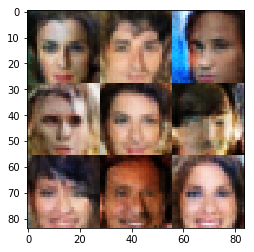

Epoch: 1/1 Iteration: 6010 Discrim. Loss: 2.0527 Generat. Loss: 0.2370
Epoch: 1/1 Iteration: 6020 Discrim. Loss: 1.9484 Generat. Loss: 0.2582
Epoch: 1/1 Iteration: 6030 Discrim. Loss: 1.6853 Generat. Loss: 0.3973
Epoch: 1/1 Iteration: 6040 Discrim. Loss: 1.2001 Generat. Loss: 0.6599
Epoch: 1/1 Iteration: 6050 Discrim. Loss: 1.4250 Generat. Loss: 0.6454
Epoch: 1/1 Iteration: 6060 Discrim. Loss: 1.5476 Generat. Loss: 0.5708
Epoch: 1/1 Iteration: 6070 Discrim. Loss: 1.9898 Generat. Loss: 0.2429
Epoch: 1/1 Iteration: 6080 Discrim. Loss: 1.8738 Generat. Loss: 0.3070
Epoch: 1/1 Iteration: 6090 Discrim. Loss: 1.7935 Generat. Loss: 0.7310
Epoch: 1/1 Iteration: 6100 Discrim. Loss: 1.6262 Generat. Loss: 0.4440


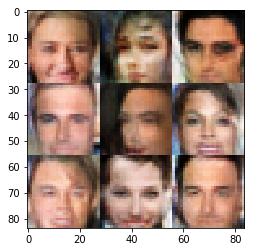

Epoch: 1/1 Iteration: 6110 Discrim. Loss: 1.9157 Generat. Loss: 0.2879
Epoch: 1/1 Iteration: 6120 Discrim. Loss: 2.0834 Generat. Loss: 0.4473
Epoch: 1/1 Iteration: 6130 Discrim. Loss: 1.9666 Generat. Loss: 0.2601
Epoch: 1/1 Iteration: 6140 Discrim. Loss: 2.1022 Generat. Loss: 0.2365
Epoch: 1/1 Iteration: 6150 Discrim. Loss: 1.8949 Generat. Loss: 0.3087
Epoch: 1/1 Iteration: 6160 Discrim. Loss: 1.6528 Generat. Loss: 0.3777
Epoch: 1/1 Iteration: 6170 Discrim. Loss: 2.0804 Generat. Loss: 0.2424
Epoch: 1/1 Iteration: 6180 Discrim. Loss: 1.7895 Generat. Loss: 0.3864
Epoch: 1/1 Iteration: 6190 Discrim. Loss: 2.2667 Generat. Loss: 0.1817
Epoch: 1/1 Iteration: 6200 Discrim. Loss: 1.9163 Generat. Loss: 0.2591


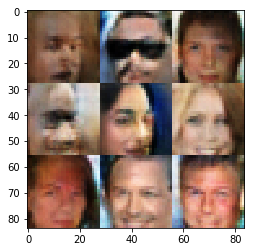

Epoch: 1/1 Iteration: 6210 Discrim. Loss: 1.9502 Generat. Loss: 0.2568
Epoch: 1/1 Iteration: 6220 Discrim. Loss: 2.3018 Generat. Loss: 0.1725
Epoch: 1/1 Iteration: 6230 Discrim. Loss: 1.9505 Generat. Loss: 0.2788
Epoch: 1/1 Iteration: 6240 Discrim. Loss: 1.8517 Generat. Loss: 0.2856
Epoch: 1/1 Iteration: 6250 Discrim. Loss: 1.8469 Generat. Loss: 0.2890
Epoch: 1/1 Iteration: 6260 Discrim. Loss: 1.8036 Generat. Loss: 0.3164
Epoch: 1/1 Iteration: 6270 Discrim. Loss: 1.6732 Generat. Loss: 0.4001
Epoch: 1/1 Iteration: 6280 Discrim. Loss: 2.0565 Generat. Loss: 0.2456
Epoch: 1/1 Iteration: 6290 Discrim. Loss: 1.8084 Generat. Loss: 0.2849
Epoch: 1/1 Iteration: 6300 Discrim. Loss: 2.3184 Generat. Loss: 0.1726


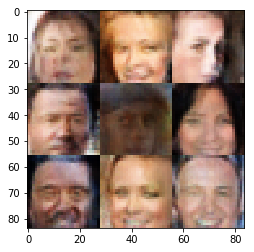

Epoch: 1/1 Iteration: 6310 Discrim. Loss: 1.7697 Generat. Loss: 0.4414
Epoch: 1/1 Iteration: 6320 Discrim. Loss: 2.1687 Generat. Loss: 0.1937
Epoch: 1/1 Iteration: 6330 Discrim. Loss: 1.7792 Generat. Loss: 0.4990


In [33]:
batch_size = 32
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.